# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

ModuleNotFoundError: No module named 'lifelines'

## 0- functions

In [ ]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [ ]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [ ]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [ ]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [ ]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_lrti_admitted', 'duration_lrti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [ ]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [ ]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [ ]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [ ]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [ ]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [ ]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [ ]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [ ]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [ ]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [ ]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [ ]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [ ]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

data.shape

(200000, 224)

In [ ]:
# # save model outputs
# a = open("../output/hospitalisation_prediction_lrti/data_lrti_record_cph_lrti.txt", "w")
# a.write("")
# a.writelines(['data_lrti_1 #with a record, #with no record: %.0f' % (data['lrti_date_1'].notna().sum()), ', %.0f' % (data['lrti_date_1'].isna().sum()),
#               '\ndata_lrti_2 #with a record, #with no record: %.0f' % (data['lrti_date_2'].notna().sum()), ', %.0f' % (data['lrti_date_2'].isna().sum()),
#               '\ndata_lrti_3 #with a record, #with no record: %.0f' % (data['lrti_date_3'].notna().sum()), ', %.0f' % (data['lrti_date_3'].isna().sum()),
#               '\ndata_lrti_4 #with a record, #with no record: %.0f' % (data['lrti_date_4'].notna().sum()), ', %.0f' % (data['lrti_date_4'].isna().sum()),
#               '\ndata_lrti_5 #with a record, #with no record: %.0f' % (data['lrti_date_5'].notna().sum()), ', %.0f' % (data['lrti_date_5'].isna().sum()),
#               '\ndata_lrti_6 #with a record, #with no record: %.0f' % (data['lrti_date_6'].notna().sum()), ', %.0f' % (data['lrti_date_6'].isna().sum()),
#               '\ndata_lrti_7 #with a record, #with no record: %.0f' % (data['lrti_date_7'].notna().sum()), ', %.0f' % (data['lrti_date_7'].isna().sum()),
#               '\ndata_lrti_8 #with a record, #with no record: %.0f' % (data['lrti_date_8'].notna().sum()), ', %.0f' % (data['lrti_date_8'].isna().sum()),
#               '\ndata_lrti_9 #with a record, #with no record: %.0f' % (data['lrti_date_9'].notna().sum()), ', %.0f' % (data['lrti_date_9'].isna().sum()),
#               '\ndata_lrti_10 #with a record, #with no record: %.0f' % (data['lrti_date_10'].notna().sum()), ', %.0f' % (data['lrti_date_10'].isna().sum()),
#               '\ndata_lrti_11 #with a record, #with no record: %.0f' % (data['lrti_date_11'].notna().sum()), ', %.0f' % (data['lrti_date_11'].isna().sum()),
#               '\ndata_lrti_12 #with a record, #with no record: %.0f' % (data['lrti_date_12'].notna().sum()), ', %.0f' % (data['lrti_date_12'].isna().sum()),
#               '\ndata_lrti_13 #with a record, #with no record: %.0f' % (data['lrti_date_13'].notna().sum()), ', %.0f' % (data['lrti_date_13'].isna().sum()),
#               '\ndata_lrti_14 #with a record, #with no record: %.0f' % (data['lrti_date_14'].notna().sum()), ', %.0f' % (data['lrti_date_14'].isna().sum()),
#               '\ndata_lrti_15 #with a record, #with no record: %.0f' % (data['lrti_date_15'].notna().sum()), ', %.0f' % (data['lrti_date_15'].isna().sum()),
#               '\ndata_lrti_16 #with a record, #with no record: %.0f' % (data['lrti_date_16'].notna().sum()), ', %.0f' % (data['lrti_date_16'].isna().sum()),
#               '\ndata_lrti_17 #with a record, #with no record: %.0f' % (data['lrti_date_17'].notna().sum()), ', %.0f' % (data['lrti_date_17'].isna().sum()),
#               '\ndata_lrti_18 #with a record, #with no record: %.0f' % (data['lrti_date_18'].notna().sum()), ', %.0f' % (data['lrti_date_18'].isna().sum()),
#               '\ndata_lrti_19 #with a record, #with no record: %.0f' % (data['lrti_date_19'].notna().sum()), ', %.0f' % (data['lrti_date_19'].isna().sum()),
#               '\ndata_lrti_20 #with a record, #with no record: %.0f' % (data['lrti_date_20'].notna().sum()), ', %.0f' % (data['lrti_date_20'].isna().sum()),
#               ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [ ]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37159
1.0     36911
2.0     32866
3.0     24872
4.0     14974
6.0     12378
7.0      9946
5.0      8334
8.0      8089
9.0      5757
10.0     3379
11.0     1818
12.0     1421
13.0      821
14.0      552
15.0      339
16.0      212
17.0       96
18.0       50
19.0       16
21.0        6
20.0        4
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [ ]:
#read 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)
data_lrti.shape

(359916, 20)

### 2-2- add season, event, and duration variables
#### season

In [ ]:
# convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] #gp_cons_lrti
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_lrti.date.min()}')
print(f'max date: {data_lrti.date.max()}')
print(f'length of data_lrti: {len(data_lrti)}')

min date: 2019-01
max date: 2022-11
length of data_lrti: 359916


In [ ]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

print(data_lrti['season'].value_counts())
print(f'\nmin date: {data_lrti.date.min()}')
print(f'max date: {data_lrti.date.max()}')
print(f'length: {len(data_lrti)}')

spring    93241
summer    93241
winter    83346
autumn    69138
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 338966


In [ ]:
data_lrti = data_lrti[data_lrti['date'] <= '2019-12']
# data_lrti = data_lrti[(data_lrti['date'] >= '2020-03') & (data_lrti['date']<= '2021-03')]
# data_lrti = data_lrti[data_lrti['date'] >= '2021-04']
# print(f'min date: {data_lrti.date.min()}')
# print(f'max date: {data_lrti.date.max()}')

In [ ]:
#add period variable
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [ ]:
#scenario 1
#not hosped (nothing happened)
#data_lrti = data_lrti[data_lrti['admitted_lrti_date'].notnull()]
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0
data_lrti['event_lrti_admitted'].value_counts()

0.0    237086
Name: event_lrti_admitted, dtype: int64

In [ ]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days #gp_cons_lrti
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]
data_lrti['delta_lrti_admitted'].value_counts()

189.0     90
135.0     87
31.0      86
130.0     85
104.0     84
          ..
1414.0     1
1396.0     1
1318.0     1
1412.0     1
1382.0     1
Name: delta_lrti_admitted, Length: 1400, dtype: int64

In [ ]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_died'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_deregistered'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_lrti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

285857

In [ ]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)
data_lrti['event_lrti_admitted'].value_counts()

0.0    288812
1.0      2238
Name: event_lrti_admitted, dtype: int64

In [ ]:
#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30
data_lrti['duration_lrti_admitted'].value_counts()

30.0    288884
25.0        84
10.0        83
3.0         81
27.0        79
18.0        77
24.0        77
1.0         76
8.0         75
22.0        75
7.0         75
13.0        75
29.0        75
0.0         74
15.0        74
14.0        73
16.0        71
12.0        71
9.0         71
6.0         71
11.0        70
2.0         70
20.0        69
26.0        68
5.0         68
17.0        66
21.0        66
4.0         64
19.0        63
23.0        63
28.0        62
Name: duration_lrti_admitted, dtype: int64

In [ ]:
# give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1
data_lrti['event_lrti_admitted'].value_counts()

0.0    288808
1.0      2242
Name: event_lrti_admitted, dtype: int64

In [ ]:
#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

In [ ]:
# data_lrti[data_lrti['duration_lrti_admitted']==0][['delta_lrti_admitted', 'lrti_date', 'gp_cons_lrti', 'admitted_lrti_date', 'delta_lrti_admitted', 'delta_admitted_died_deregistered', 'event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[151:200, ['event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[201:250, ['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])
data_lrti[['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])

,event_lrti_admitted,duration_lrti_admitted
196199,1.0,1.0
195516,1.0,1.0
24750,1.0,1.0
306975,1.0,1.0
152202,1.0,1.0
...,...,...
120493,0.0,30.0
120492,0.0,30.0
120491,0.0,30.0
120497,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [ ]:
# prep before plot
data_lrti['age'][data_lrti['age'] < 0] = np.nan
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_lrti = data_lrti[~(data_lrti['age'] < 18)]  
print(f'Min age: {data_lrti.age.min()}')

## remove died cases
#data_lrti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
# replace 0s with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [ ]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [ ]:
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_lrti['region_imp'] = data_lrti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_lrti.region.isnull().sum()}')
    data_lrti = data_lrti[data_lrti['region'].notna()]

print(f'Cound of missing values in variable region: {data_lrti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_lrti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35014
Yorkshire and The Humber    17803
North West                  17771
East Midlands               17717
East                        17676
West Midlands               17584
South East                  17560
South West                  17403
North East                  17364
Name: region, dtype: int64


In [ ]:
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_lrti.antibacterial_brit.mean():.3f}')
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)
    # data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_lrti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.257

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.257


In [ ]:
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_lrti.ethnicity.value_counts()}')
    # data_lrti['ethnicity'] = data_lrti['ethnicity'].astype(str)
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_lrti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 43787
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    106002
5.0     13132
3.0     12971
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    106002
0.0     43787
5.0     13132
3.0     12971
Name: ethnicity, dtype: int64


In [ ]:
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_lrti.smoking_status.value_counts()}')
    # data_lrti['smoking_status'] = data_lrti['smoking_status'].astype(str)
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_lrti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73053
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    68627
3.0    22781
2.0    11431
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73053
1.0    68627
3.0    22781
2.0    11431
Name: smoking_status, dtype: int64


In [ ]:
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_lrti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_lrti.imd.value_counts()}')
    # data_lrti['imd'] = data_lrti['imd'].astype(str)
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_lrti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_lrti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    33695
1    33607
2    33356
5    33307
4    33255
0     8672
Name: imd, dtype: int64


In [ ]:
data_lrti['bmi_cat'] = 5
col_bmi_cat = data_lrti.columns.get_loc('bmi_cat')

col_sex = data_lrti.columns.get_loc('sex')
col_age = data_lrti.columns.get_loc('age')
col_bmi = data_lrti.columns.get_loc('bmi')

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, col_bmi] >= 30:
        data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_lrti.iat[idx, col_bmi] >= 25) and (data_lrti.iat[idx, col_bmi] < 30):
        data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_lrti.iat[idx, col_bmi] >= 18.5) and (data_lrti.iat[idx, col_bmi] < 25):
        data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_lrti.iat[idx, col_bmi] < 18.5:
        data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_lrti['bmi_cat'].value_counts()

1    91430
5    44904
2    19486
3    14410
4     5662
Name: bmi_cat, dtype: int64

In [ ]:
if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')
    # data_lrti['bmi_cat'] = data_lrti['bmi_cat'].astype(str)
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    91430
5    44904
2    19486
3    14410
4     5662
Name: bmi_cat, dtype: int64


In [ ]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])

#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)
data_lrti['ab_type_cat'].value_counts()

no             158429
0               14042
other            2113
Amoxicillin       955
Doxycycline       353
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [ ]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [ ]:
# reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})
data_lrti['ab_type_cat'].value_counts()

no             158429
other           16155
Amoxicillin       955
Doxycycline       353
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [ ]:
# categorising
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_lrti['CCI_cat'].value_counts()

low          61355
medium       35362
very_low     32198
very_high    28691
high         18286
Name: CCI_cat, dtype: int64

In [ ]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)
data_lrti['antibacterial_brit'].max()

data_lrti['antibacterial_brit_cat'] = pd.cut(data_lrti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_lrti['antibacterial_brit_cat'].value_counts()

low       101590
high       44171
medium     30131
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

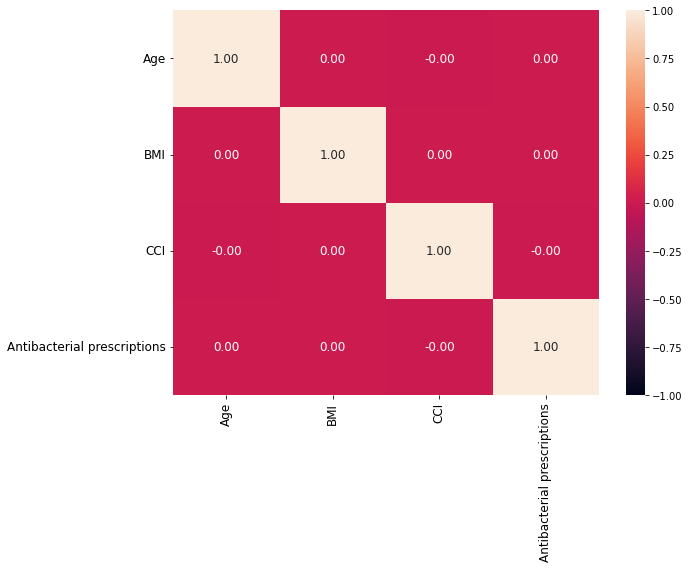

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

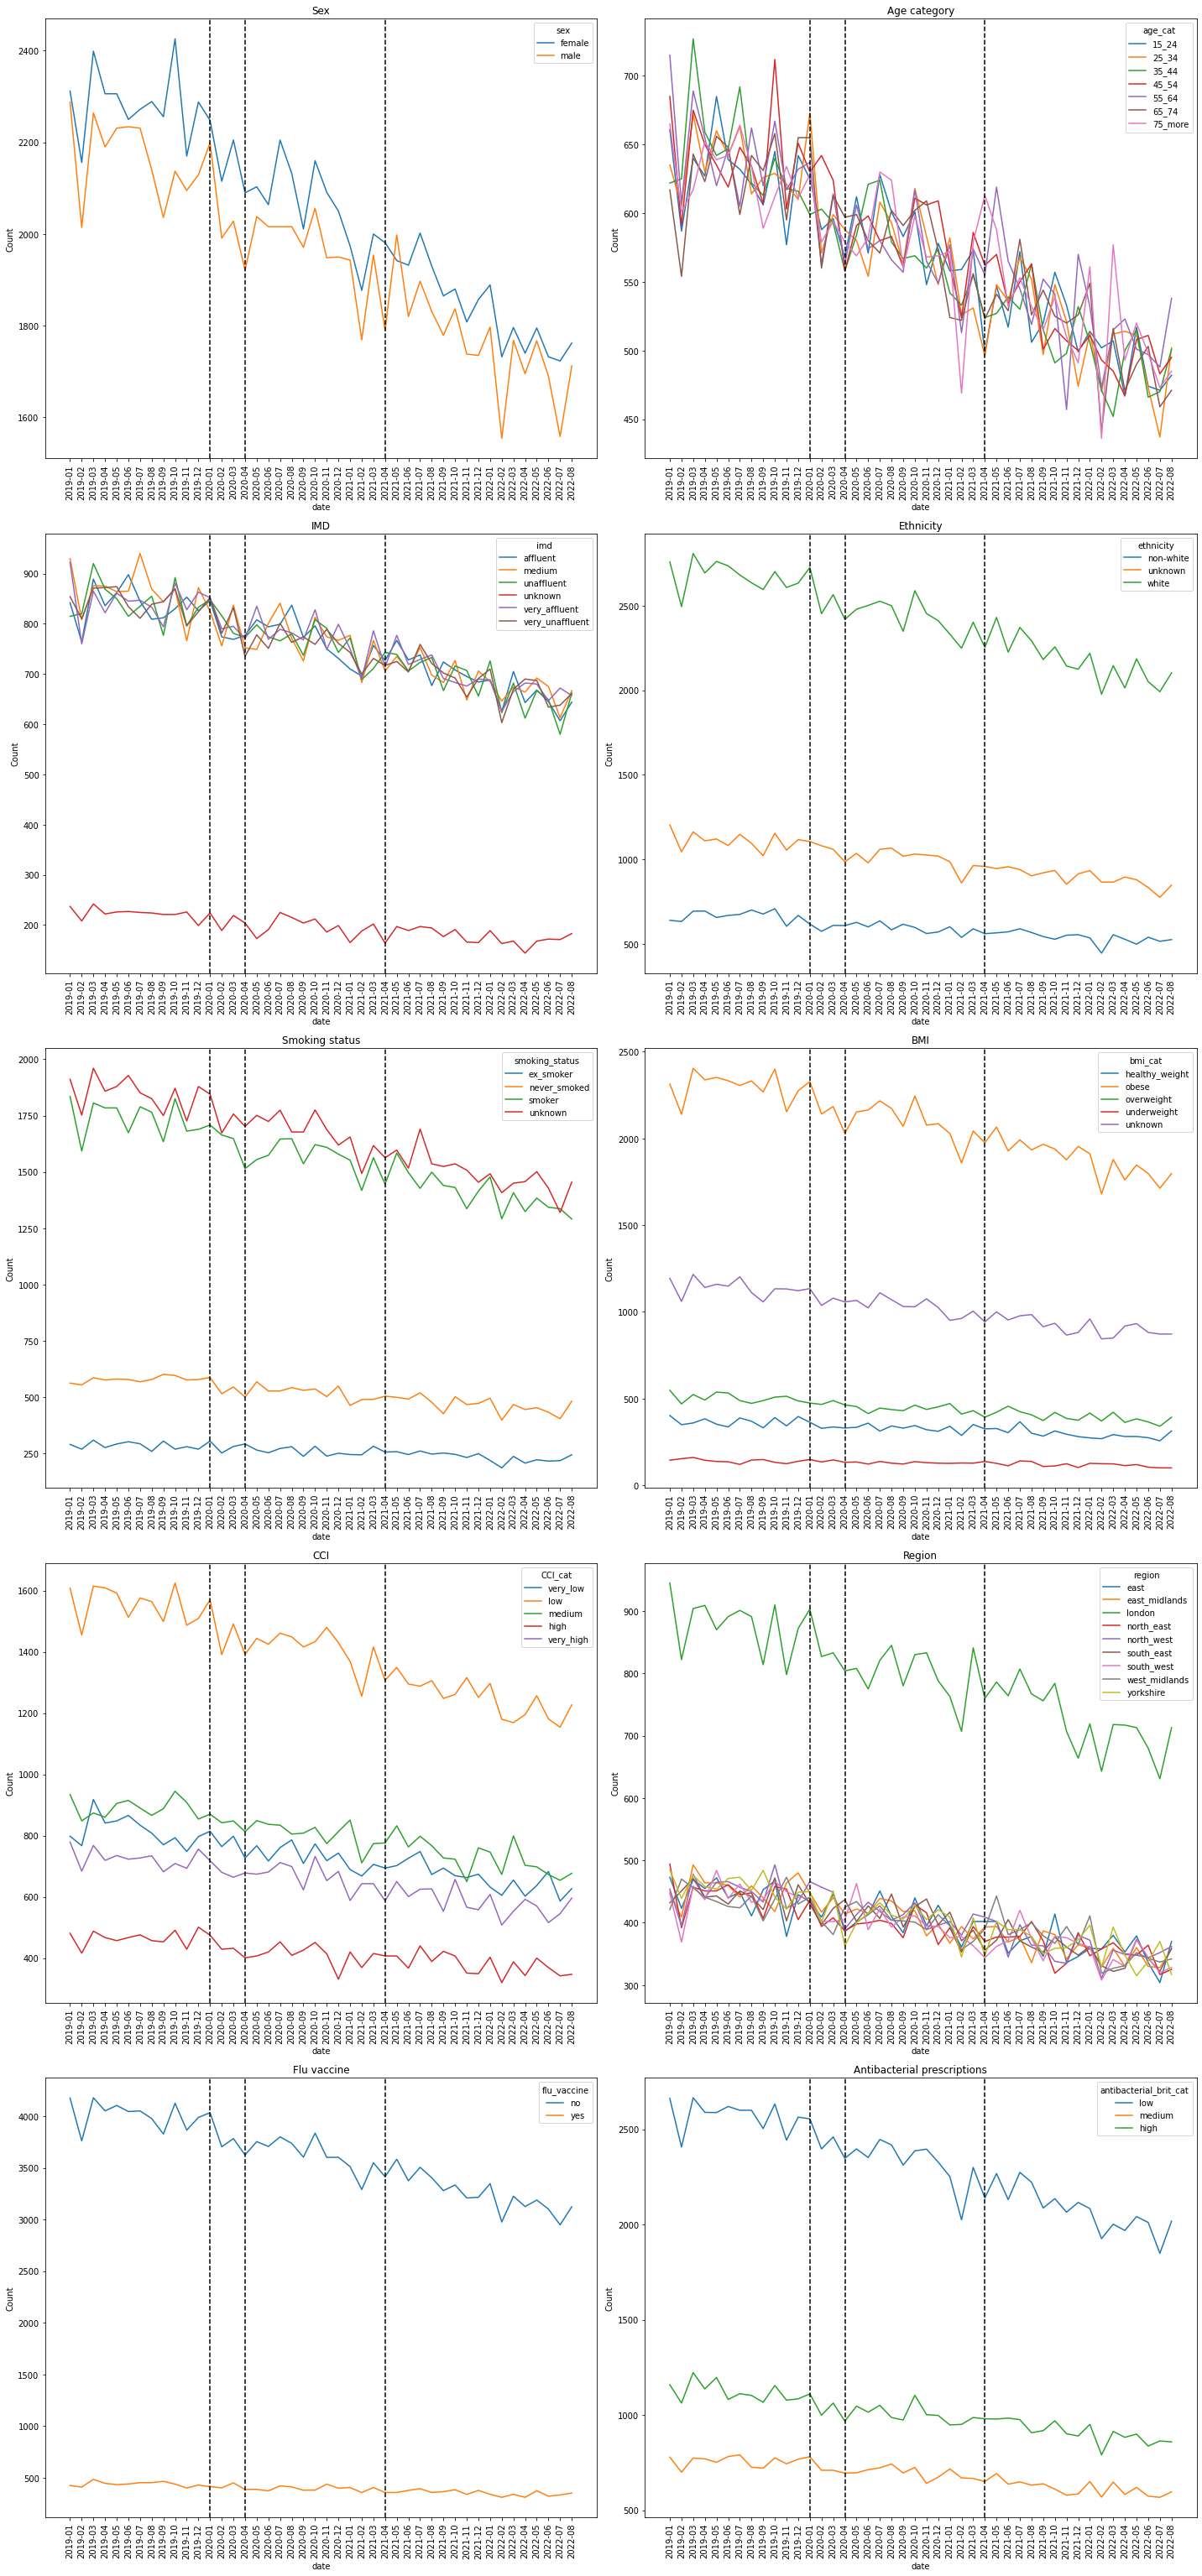

In [ ]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_lrti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_lrti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_lrti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_lrti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_lrti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_lrti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_lrti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_lrti, 'region', 'Region', axes[3,1])
create_lineplot(data_lrti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_lrti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of lrti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/risk_factors_cat_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of lrti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [ ]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                       'event_lrti_admitted', 'duration_lrti_admitted'
                        ]]

data_lrti.shape

(175892, 18)

In [ ]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_lrti_incdt_abtype_0 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[0]]
# data_lrti_incdt_abtype_1 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[1]]
# data_lrti_incdt_abtype_2 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[2]]
# data_lrti_incdt_abtype_3 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[3]]
# data_lrti_prevl_abtype_0 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[0]]
# data_lrti_prevl_abtype_1 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[1]]
# data_lrti_prevl_abtype_2 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[2]]
# data_lrti_prevl_abtype_3 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_lrti_incdt_abs = data_lrti_incdt[data_lrti_incdt['lrti_ab_date'] == 1]
# data_lrti_prevl_abs = data_lrti_prevl[data_lrti_prevl['lrti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()] #gp_cons_lrti_ab
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

print(f'shape of data_lrti_incdt: {data_lrti_incdt.shape}')
print(f'shape of data_lrti_prevl: {data_lrti_prevl.shape}')
print(f'shape of data_lrti_no_abs_incdt: {data_lrti_no_abs_incdt.shape}')
print(f'shape of data_lrti_abs_incdt: {data_lrti_abs_incdt.shape}')
print(f'shape of data_lrti_no_abs_prevl: {data_lrti_no_abs_prevl.shape}')
print(f'shape of data_lrti_abs_prevl: {data_lrti_abs_prevl.shape}')
print(f'\nvalue counts of data_lrti_no_abs_incdt: \n{data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'value counts of data_lrti_abs_incdt: \n{data_lrti_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'value counts of data_lrti_no_abs_prevl: \n{data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()}')
print(f'value counts of data_lrti_abs_prevl: \n{data_lrti_abs_prevl.event_lrti_admitted.value_counts()}')

shape of data_lrti_incdt: (158299, 18)
shape of data_lrti_prevl: (17593, 18)
shape of data_lrti_no_abs_incdt: (142563, 18)
shape of data_lrti_abs_incdt: (15736, 18)
shape of data_lrti_no_abs_prevl: (15866, 18)
shape of data_lrti_abs_prevl: (1727, 18)

value counts of data_lrti_no_abs_incdt: 
0.0    141460
1.0      1103
Name: event_lrti_admitted, dtype: int64
value counts of data_lrti_abs_incdt: 
0.0    15602
1.0      134
Name: event_lrti_admitted, dtype: int64
value counts of data_lrti_no_abs_prevl: 
0.0    15768
1.0       98
Name: event_lrti_admitted, dtype: int64
value counts of data_lrti_abs_prevl: 
0.0    1717
1.0      10
Name: event_lrti_admitted, dtype: int64


In [ ]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 106922 total observations, 106100 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 106922
number of events observed = 822
   partial log-likelihood = -9487.35
         time fit was run = 2022-11-22 18:58:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.10            -0.24             0.15                 0.79                 1.16
CCI_cat[T.medium]               -0.17       0.85       0.11            -0.39             0.06                 0.68                 1.06
CCI_cat[T.high]                 -0.04       0.96       0.13            -0.30             0.22                 0.74                 1.24
CCI_cat[T.very_high]            -0.08       0.92       0.12            -0.31             0.15                 0.73                 1.16
age_cat[T.25_34]                -0.09       0.92       0.13            -0.35             0.17                 0.70                 1.19
age_cat[T.35_44]                 0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
age_cat[T.45_54]                -0.07       0.93       0.13            -0.33             0.19                 0.72                 1.21
age_cat[T.55_64]                -0.05       0.95       0.13            -0.30             0.21                 0.74                 1.24
age_cat[T.65_74]                 0.16       1.17       0.13            -0.09             0.41                 0.92                 1.50
age_cat[T.75_more]              -0.06       0.95       0.13            -0.31             0.20                 0.73                 1.22
antibacterial_brit               0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
bmi_cat[T.obese]                 0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
bmi_cat[T.overweight]            0.16       1.18       0.16            -0.15             0.48                 0.86                 1.61
bmi_cat[T.underweight]          -0.08       0.92       0.24            -0.56             0.39                 0.57                 1.48
bmi_cat[T.unknown]               0.03       1.03       0.14            -0.25             0.31                 0.78                 1.36
ethnicity[T.unknown]            -0.07       0.93       0.12            -0.30             0.16                 0.74                 1.17
ethnicity[T.white]               0.05       1.05       0.10            -0.15             0.25                 0.86                 1.28
flu_vaccine[T.yes]               0.07       1.07       0.11            -0.16             0.29                 0.86                 1.34
imd[T.medium]                   -0.23       0.79       0.12            -0.46            -0.00                 0.63                 1.00
imd[T.unaffluent]                0.01       1.01       0.11            -0.21             0.22                 0.81                 1.25
imd[T.unknown]                   0.10       1.10       0.17            -0.23             0.42                 0.80                 1.53
imd[T.very_affluent]            -0.17       0.84       0.12            -0.40             0.06                 0.67                 1.06
imd[T.very_unaffluent]           0.07       1.08       0.11            -0.14             0.29                 0.87                 1.33
region[T.east_midlands]         -0.10       0.91       0.17            -0.43             0.23                 0.65                 1.26
region[T.london]                 0.07       1.07       0.14      

12772

error_2: betas or sum of betas failed.


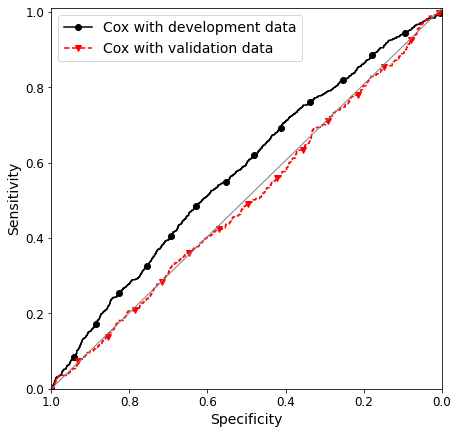

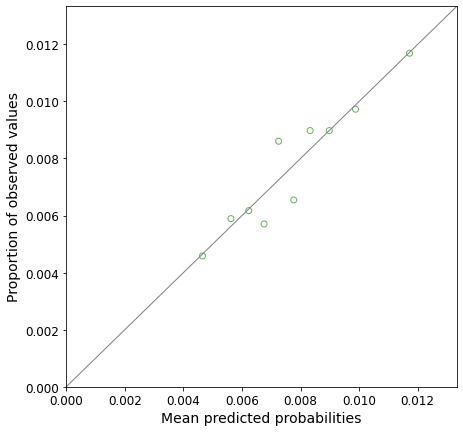

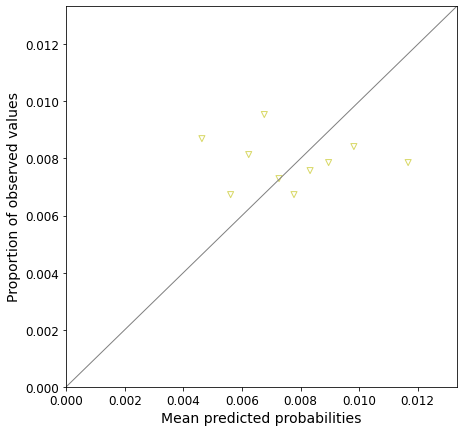

In [ ]:
#data prep
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

try:
    #build cox model 
    cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 11802 total observations, 11704 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 11802
number of events observed = 98
   partial log-likelihood = -904.29
         time fit was run = 2022-11-22 18:38:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.48       1.62       0.31            -0.12             1.09                 0.88                 2.97
CCI_cat[T.medium]                0.30       1.35       0.35            -0.38             0.98                 0.69                 2.65
CCI_cat[T.high]                  0.11       1.12       0.43            -0.72             0.95                 0.48                 2.59
CCI_cat[T.very_high]            -0.01       0.99       0.39            -0.78             0.76                 0.46                 2.15
age_cat[T.25_34]                 0.19       1.21       0.37            -0.54             0.92                 0.58                 2.52
age_cat[T.35_44]                -0.08       0.92       0.40            -0.87             0.70                 0.42                 2.02
age_cat[T.45_54]                 0.33       1.39       0.36            -0.38             1.04                 0.68                 2.84
age_cat[T.55_64]                -0.18       0.84       0.41            -0.98             0.63                 0.37                 1.87
age_cat[T.65_74]                 0.15       1.16       0.38            -0.60             0.89                 0.55                 2.43
age_cat[T.75_more]              -0.02       0.98       0.39            -0.79             0.75                 0.45                 2.11
antibacterial_brit               0.00       1.00       0.07            -0.14             0.14                 0.87                 1.15
bmi_cat[T.obese]                 0.10       1.11       0.40            -0.69             0.89                 0.50                 2.44
bmi_cat[T.overweight]            0.31       1.36       0.46            -0.60             1.22                 0.55                 3.39
bmi_cat[T.underweight]           0.88       2.41       0.54            -0.17             1.93                 0.84                 6.88
bmi_cat[T.unknown]              -0.25       0.78       0.45            -1.12             0.62                 0.32                 1.87
ethnicity[T.unknown]            -0.06       0.95       0.34            -0.72             0.61                 0.49                 1.84
ethnicity[T.white]               0.08       1.08       0.30            -0.50             0.66                 0.61                 1.94
flu_vaccine[T.yes]               0.07       1.08       0.33            -0.58             0.73                 0.56                 2.07
imd[T.medium]                   -0.36       0.70       0.30            -0.95             0.23                 0.39                 1.25
imd[T.unaffluent]               -0.46       0.63       0.31            -1.07             0.15                 0.34                 1.16
imd[T.unknown]                  -0.85       0.43       0.61            -2.05             0.34                 0.13                 1.41
imd[T.very_affluent]            -0.60       0.55       0.32            -1.23             0.03                 0.29                 1.03
imd[T.very_unaffluent]          -0.45       0.64       0.31            -1.06             0.16                 0.35                 1.17
region[T.east_midlands]          0.04       1.04       0.50            -0.94             1.02                 0.39                 2.79
region[T.london]                 0.19       1.21       0.42           

12758


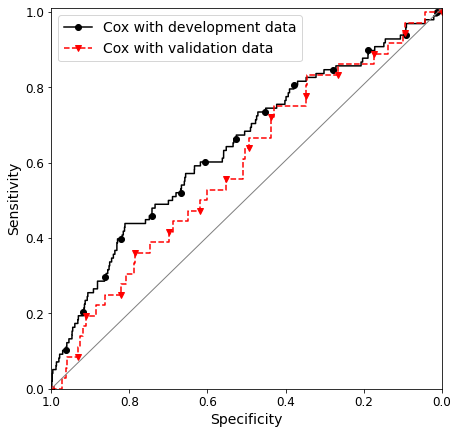

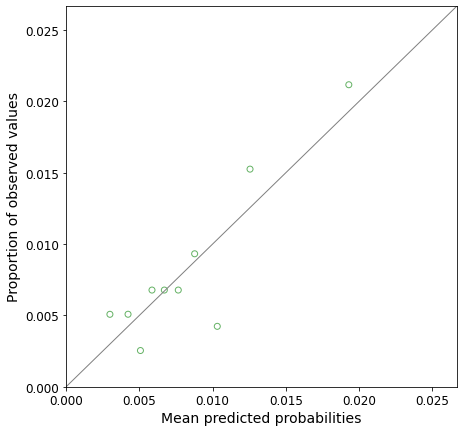

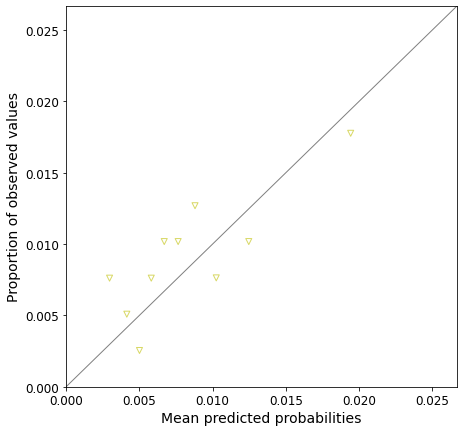

In [ ]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

try:
    #build cox model 
    cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 11899 total observations, 11822 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 11899
number of events observed = 77
   partial log-likelihood = -710.85
         time fit was run = 2022-11-22 18:39:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.32       0.72       0.31            -0.93             0.28                 0.40                 1.32
CCI_cat[T.medium]               -0.14       0.87       0.33            -0.79             0.52                 0.45                 1.68
CCI_cat[T.high]                 -0.42       0.66       0.45            -1.29             0.46                 0.27                 1.58
CCI_cat[T.very_high]            -0.74       0.48       0.43            -1.58             0.09                 0.21                 1.10
age_cat[T.25_34]                -0.45       0.64       0.40            -1.24             0.34                 0.29                 1.41
age_cat[T.35_44]                -0.49       0.61       0.40            -1.28             0.30                 0.28                 1.35
age_cat[T.45_54]                -0.23       0.79       0.37            -0.97             0.50                 0.38                 1.65
age_cat[T.55_64]                -0.69       0.50       0.43            -1.54             0.16                 0.21                 1.17
age_cat[T.65_74]                -0.43       0.65       0.39            -1.20             0.33                 0.30                 1.40
age_cat[T.75_more]              -0.55       0.58       0.42            -1.36             0.27                 0.26                 1.31
antibacterial_brit               0.07       1.07       0.08            -0.09             0.22                 0.92                 1.24
bmi_cat[T.obese]                 0.39       1.48       0.47            -0.54             1.32                 0.58                 3.73
bmi_cat[T.overweight]            0.23       1.26       0.57            -0.89             1.35                 0.41                 3.85
bmi_cat[T.underweight]           0.83       2.30       0.67            -0.49             2.15                 0.62                 8.58
bmi_cat[T.unknown]               0.02       1.02       0.52            -1.00             1.03                 0.37                 2.80
ethnicity[T.unknown]            -0.21       0.81       0.40            -0.99             0.57                 0.37                 1.77
ethnicity[T.white]               0.13       1.14       0.33            -0.53             0.78                 0.59                 2.18
flu_vaccine[T.yes]               0.26       1.30       0.34            -0.41             0.93                 0.67                 2.52
imd[T.medium]                    0.26       1.30       0.39            -0.50             1.02                 0.61                 2.79
imd[T.unaffluent]                0.04       1.04       0.41            -0.76             0.84                 0.47                 2.32
imd[T.unknown]                   0.02       1.02       0.65            -1.25             1.28                 0.29                 3.61
imd[T.very_affluent]             0.53       1.71       0.37            -0.18             1.25                 0.83                 3.50
imd[T.very_unaffluent]           0.25       1.28       0.39            -0.51             1.01                 0.60                 2.74
region[T.east_midlands]         -0.96       0.38       0.59            -2.12             0.20                 0.12                 1.22
region[T.london]                -0.21       0.81       0.40           

12768


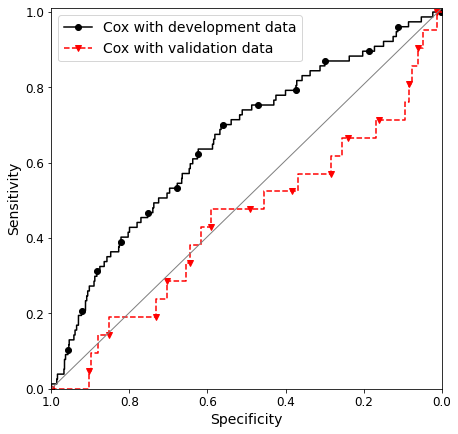

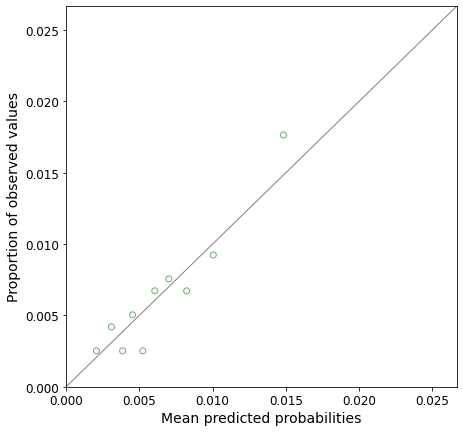

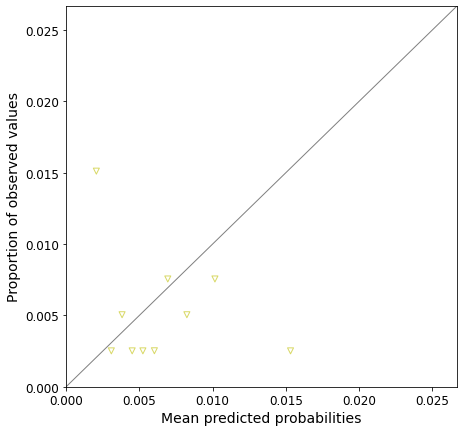

In [ ]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

try:
    #build cox model 
    cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 1295 total observations, 1288 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1295
number of events observed = 7
   partial log-likelihood = -24.80
         time fit was run = 2022-11-22 18:39:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.22       3.38       1.65            -2.02             4.46                 0.13                86.36
CCI_cat[T.medium]                0.52       1.69       1.93            -3.25             4.30                 0.04                73.37
CCI_cat[T.high]                -19.15       0.00   10976.46        -21532.61         21494.31                 0.00                  inf
CCI_cat[T.very_high]             1.42       4.16       1.93            -2.36             5.21                 0.09               183.16
age_cat[T.25_34]               -22.14       0.00    6338.05        -12444.48         12400.21                 0.00                  inf
age_cat[T.35_44]               -22.75       0.00    4386.14         -8619.42          8573.93                 0.00                  inf
age_cat[T.45_54]                -2.23       0.11       2.14            -6.42             1.96                 0.00                 7.06
age_cat[T.55_64]                -0.97       0.38       2.69            -6.24             4.31                 0.00                74.09
age_cat[T.65_74]                 0.11       1.12       1.93            -3.68             3.90                 0.03                49.49
age_cat[T.75_more]              -0.29       0.75       2.20            -4.61             4.02                 0.01                55.50
antibacterial_brit               1.25       3.49       0.52             0.23             2.27                 1.26                 9.66
bmi_cat[T.obese]                -0.66       0.52       1.87            -4.32             3.00                 0.01                20.14
bmi_cat[T.overweight]           -2.55       0.08       2.54            -7.52             2.43                 0.00                11.40
bmi_cat[T.underweight]         -18.84       0.00   17316.63        -33958.81         33921.12                 0.00                  inf
bmi_cat[T.unknown]              -1.75       0.17       2.30            -6.26             2.76                 0.00                15.77
ethnicity[T.unknown]            -1.65       0.19       1.65            -4.88             1.57                 0.01                 4.82
ethnicity[T.white]              -2.81       0.06       1.51            -5.78             0.15                 0.00                 1.17
flu_vaccine[T.yes]               3.09      21.90       1.80            -0.44             6.61                 0.65               741.63
imd[T.medium]                  -22.36       0.00    5609.78        -11017.33         10972.61                 0.00                  inf
imd[T.unaffluent]                0.85       2.34       1.39            -1.87             3.57                 0.15                35.46
imd[T.unknown]                 -13.99       0.00   16328.23        -32016.74         31988.76                 0.00                  inf
imd[T.very_affluent]            -0.34       0.72       1.37            -3.02             2.35                 0.05                10.50
imd[T.very_unaffluent]          -2.73       0.06       1.90            -6.46             0.99                 0.00                 2.69
region[T.east_midlands]         -0.22       0.81   28372.98        -55610.24         55609.81                 0.00                  inf
region[T.london]                19.58   3.18e+08   20292.54        -39753.0

13019


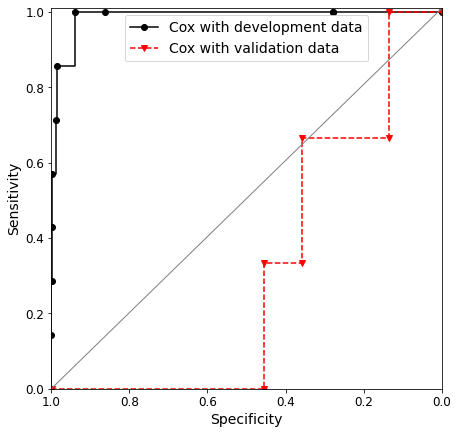

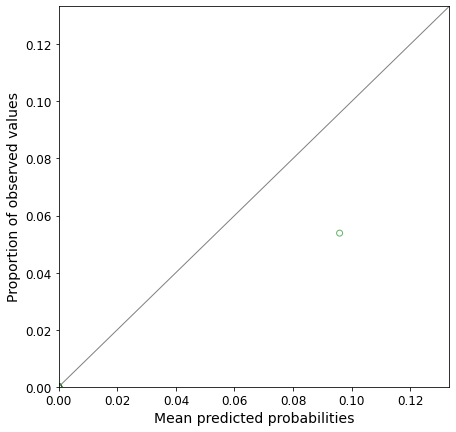

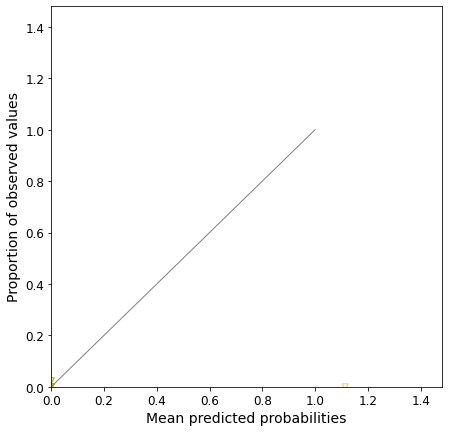

In [ ]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

try:
    #build cox model 
    cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident lrti

In [ ]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

try:
    cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 118724 total observations, 117787 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 118724
number of events observed = 937
   partial log-likelihood = -10921.56
         time fit was run = 2022-11-22 18:39:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.09            -0.15             0.22                 0.86                 1.25
CCI_cat[T.medium]               -0.11       0.90       0.11            -0.32             0.10                 0.72                 1.11
CCI_cat[T.high]                 -0.07       0.93       0.13            -0.33             0.18                 0.72                 1.20
CCI_cat[T.very_high]             0.11       1.11       0.11            -0.10             0.32                 0.90                 1.38
age_cat[T.25_34]                 0.02       1.02       0.12            -0.22             0.26                 0.80                 1.30
age_cat[T.35_44]                 0.04       1.04       0.12            -0.20             0.28                 0.82                 1.33
age_cat[T.45_54]                 0.08       1.09       0.12            -0.15             0.32                 0.86                 1.38
age_cat[T.55_64]                -0.07       0.93       0.13            -0.32             0.17                 0.73                 1.19
age_cat[T.65_74]                 0.15       1.16       0.12            -0.08             0.39                 0.92                 1.47
age_cat[T.75_more]              -0.07       0.94       0.13            -0.31             0.18                 0.73                 1.20
antibacterial_brit               0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                -0.04       0.96       0.12            -0.28             0.20                 0.76                 1.22
bmi_cat[T.overweight]            0.08       1.09       0.15            -0.20             0.37                 0.82                 1.44
bmi_cat[T.underweight]           0.11       1.12       0.20            -0.29             0.51                 0.75                 1.66
bmi_cat[T.unknown]              -0.11       0.90       0.13            -0.37             0.15                 0.69                 1.16
ethnicity[T.unknown]            -0.09       0.92       0.11            -0.30             0.13                 0.74                 1.14
ethnicity[T.white]               0.03       1.03       0.09            -0.16             0.21                 0.85                 1.24
flu_vaccine[T.yes]              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.19
imd[T.medium]                   -0.16       0.85       0.11            -0.37             0.05                 0.69                 1.05
imd[T.unaffluent]                0.00       1.00       0.10            -0.20             0.20                 0.82                 1.22
imd[T.unknown]                   0.01       1.01       0.16            -0.30             0.32                 0.74                 1.38
imd[T.very_affluent]            -0.20       0.82       0.11            -0.41             0.01                 0.66                 1.01
imd[T.very_unaffluent]          -0.02       0.98       0.10            -0.22             0.18                 0.80                 1.20
lrti_ab_date                     0.12       1.13       0.10            -0.08             0.33                 0.92                 1.39
region[T.east_midlands]          0.14       1.15       0.15     

13045


### 5-6- hospital admission related to prevalent lrti

In [ ]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

try:
    cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13194 total observations, 13119 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13194
number of events observed = 75
   partial log-likelihood = -693.90
         time fit was run = 2022-11-22 18:39:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.31            -0.56             0.64                 0.57                 1.90
CCI_cat[T.medium]               -0.32       0.73       0.37            -1.05             0.42                 0.35                 1.52
CCI_cat[T.high]                 -0.79       0.45       0.56            -1.89             0.31                 0.15                 1.36
CCI_cat[T.very_high]            -0.53       0.59       0.42            -1.35             0.29                 0.26                 1.33
age_cat[T.25_34]                -0.35       0.71       0.40            -1.13             0.43                 0.32                 1.54
age_cat[T.35_44]                -0.53       0.59       0.42            -1.36             0.29                 0.26                 1.34
age_cat[T.45_54]                -0.81       0.45       0.46            -1.71             0.09                 0.18                 1.09
age_cat[T.55_64]                -0.20       0.82       0.38            -0.94             0.55                 0.39                 1.73
age_cat[T.65_74]                -0.46       0.63       0.41            -1.27             0.34                 0.28                 1.40
age_cat[T.75_more]              -0.46       0.63       0.41            -1.26             0.34                 0.28                 1.40
antibacterial_brit              -0.00       1.00       0.08            -0.16             0.16                 0.85                 1.17
bmi_cat[T.obese]                 0.17       1.19       0.44            -0.68             1.03                 0.51                 2.79
bmi_cat[T.overweight]           -0.42       0.66       0.61            -1.61             0.77                 0.20                 2.15
bmi_cat[T.underweight]           0.55       1.73       0.65            -0.72             1.82                 0.49                 6.15
bmi_cat[T.unknown]              -0.13       0.88       0.48            -1.07             0.81                 0.34                 2.24
ethnicity[T.unknown]            -0.18       0.83       0.41            -1.00             0.63                 0.37                 1.88
ethnicity[T.white]               0.19       1.21       0.35            -0.49             0.87                 0.61                 2.39
flu_vaccine[T.yes]              -0.11       0.90       0.40            -0.88             0.67                 0.41                 1.96
imd[T.medium]                    0.39       1.48       0.39            -0.38             1.16                 0.68                 3.19
imd[T.unaffluent]                0.40       1.50       0.39            -0.36             1.17                 0.69                 3.23
imd[T.unknown]                  -0.99       0.37       1.05            -3.04             1.06                 0.05                 2.89
imd[T.very_affluent]             0.45       1.58       0.38            -0.30             1.21                 0.74                 3.34
imd[T.very_unaffluent]           0.17       1.19       0.41            -0.63             0.98                 0.53                 2.66
lrti_ab_date                     0.11       1.12       0.37            -0.62             0.85                 0.54                 2.33
region[T.east_midlands]         -0.40       0.67       0.59           

13040


### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [ ]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 118724 total observations, 117787 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 118724
number of events observed = 937
   partial log-likelihood = -10919.06
         time fit was run = 2022-11-22 18:39:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.09            -0.15             0.22                 0.86                 1.25
CCI_cat[T.medium]               -0.11       0.90       0.11            -0.32             0.10                 0.72                 1.11
CCI_cat[T.high]                 -0.07       0.93       0.13            -0.33             0.18                 0.72                 1.20
CCI_cat[T.very_high]             0.11       1.11       0.11            -0.10             0.32                 0.90                 1.38
ab_type_cat[T.Doxycycline]     -13.22       0.00     435.31          -866.41           839.96                 0.00                  inf
ab_type_cat[T.no]               -0.49       0.61       0.36            -1.19             0.20                 0.30                 1.22
ab_type_cat[T.other]            -0.38       0.69       0.37            -1.10             0.35                 0.33                 1.41
age_cat[T.25_34]                 0.02       1.02       0.12            -0.22             0.26                 0.80                 1.30
age_cat[T.35_44]                 0.04       1.04       0.12            -0.20             0.28                 0.82                 1.33
age_cat[T.45_54]                 0.08       1.09       0.12            -0.15             0.32                 0.86                 1.38
age_cat[T.55_64]                -0.07       0.93       0.13            -0.32             0.17                 0.73                 1.19
age_cat[T.65_74]                 0.15       1.16       0.12            -0.08             0.39                 0.92                 1.47
age_cat[T.75_more]              -0.07       0.93       0.13            -0.31             0.18                 0.73                 1.20
antibacterial_brit               0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                -0.04       0.96       0.12            -0.28             0.20                 0.76                 1.22
bmi_cat[T.overweight]            0.08       1.09       0.15            -0.20             0.37                 0.82                 1.45
bmi_cat[T.underweight]           0.11       1.12       0.20            -0.29             0.51                 0.75                 1.67
bmi_cat[T.unknown]              -0.11       0.90       0.13            -0.37             0.15                 0.69                 1.16
ethnicity[T.unknown]            -0.09       0.92       0.11            -0.30             0.13                 0.74                 1.14
ethnicity[T.white]               0.03       1.03       0.09            -0.16             0.21                 0.85                 1.24
flu_vaccine[T.yes]              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.19
imd[T.medium]                   -0.16       0.85       0.11            -0.37             0.05                 0.69                 1.05
imd[T.unaffluent]                0.00       1.00       0.10            -0.20             0.20                 0.82                 1.22
imd[T.unknown]                   0.01       1.01       0.16            -0.30             0.32                 0.74                 1.38
imd[T.very_affluent]            -0.20       0.82       0.11     

13620


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [ ]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13194 total observations, 13119 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13194
number of events observed = 75
   partial log-likelihood = -691.78
         time fit was run = 2022-11-22 18:39:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.31            -0.55             0.64                 0.58                 1.90
CCI_cat[T.medium]               -0.31       0.74       0.37            -1.04             0.43                 0.35                 1.53
CCI_cat[T.high]                 -0.79       0.46       0.56            -1.88             0.31                 0.15                 1.36
CCI_cat[T.very_high]            -0.52       0.59       0.42            -1.34             0.29                 0.26                 1.34
ab_type_cat[T.Doxycycline]     -15.72       0.00    2505.69         -4926.78          4895.35                 0.00                  inf
ab_type_cat[T.no]               -1.83       0.16       0.72            -3.25            -0.41                 0.04                 0.66
ab_type_cat[T.other]            -1.93       0.14       0.82            -3.55            -0.32                 0.03                 0.72
age_cat[T.25_34]                -0.34       0.71       0.40            -1.12             0.44                 0.33                 1.55
age_cat[T.35_44]                -0.52       0.59       0.42            -1.35             0.31                 0.26                 1.36
age_cat[T.45_54]                -0.80       0.45       0.46            -1.70             0.09                 0.18                 1.10
age_cat[T.55_64]                -0.19       0.83       0.38            -0.94             0.55                 0.39                 1.74
age_cat[T.65_74]                -0.46       0.63       0.41            -1.26             0.35                 0.28                 1.41
age_cat[T.75_more]              -0.45       0.64       0.41            -1.25             0.35                 0.29                 1.42
antibacterial_brit              -0.00       1.00       0.08            -0.16             0.16                 0.85                 1.17
bmi_cat[T.obese]                 0.15       1.16       0.44            -0.70             1.01                 0.49                 2.74
bmi_cat[T.overweight]           -0.47       0.63       0.61            -1.66             0.72                 0.19                 2.06
bmi_cat[T.underweight]           0.55       1.73       0.65            -0.72             1.82                 0.49                 6.15
bmi_cat[T.unknown]              -0.15       0.86       0.48            -1.09             0.79                 0.34                 2.20
ethnicity[T.unknown]            -0.19       0.83       0.41            -1.00             0.62                 0.37                 1.86
ethnicity[T.white]               0.18       1.20       0.35            -0.50             0.86                 0.61                 2.37
flu_vaccine[T.yes]              -0.11       0.89       0.40            -0.89             0.67                 0.41                 1.95
imd[T.medium]                    0.41       1.50       0.39            -0.36             1.17                 0.70                 3.24
imd[T.unaffluent]                0.42       1.52       0.39            -0.35             1.19                 0.71                 3.29
imd[T.unknown]                  -1.01       0.36       1.05            -3.06             1.04                 0.05                 2.83
imd[T.very_affluent]             0.46       1.58       0.38           

13620


### 5-9- stratified by sex
#### 5-9-1- incident males

In [ ]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 57959 total observations, 57509 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 57959
number of events observed = 450
   partial log-likelihood = -4918.39
         time fit was run = 2022-11-22 18:39:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.13            -0.25             0.27                 0.78                 1.32
CCI_cat[T.medium]                0.01       1.01       0.15            -0.29             0.31                 0.75                 1.36
CCI_cat[T.high]                 -0.09       0.92       0.19            -0.45             0.28                 0.63                 1.32
CCI_cat[T.very_high]            -0.07       0.93       0.16            -0.39             0.24                 0.68                 1.27
age_cat[T.25_34]                -0.18       0.83       0.18            -0.54             0.17                 0.58                 1.19
age_cat[T.35_44]                -0.12       0.88       0.18            -0.47             0.23                 0.62                 1.25
age_cat[T.45_54]                 0.00       1.00       0.17            -0.34             0.34                 0.71                 1.40
age_cat[T.55_64]                -0.09       0.92       0.18            -0.43             0.26                 0.65                 1.30
age_cat[T.65_74]                 0.09       1.10       0.17            -0.24             0.42                 0.79                 1.53
age_cat[T.75_more]               0.04       1.04       0.17            -0.30             0.37                 0.74                 1.45
antibacterial_brit               0.01       1.01       0.03            -0.06             0.07                 0.94                 1.08
bmi_cat[T.obese]                 0.17       1.18       0.19            -0.20             0.54                 0.82                 1.71
bmi_cat[T.overweight]            0.14       1.15       0.23            -0.30             0.59                 0.74                 1.80
bmi_cat[T.underweight]          -0.12       0.89       0.35            -0.81             0.57                 0.45                 1.76
bmi_cat[T.unknown]               0.13       1.13       0.20            -0.27             0.52                 0.77                 1.68
ethnicity[T.unknown]            -0.11       0.90       0.16            -0.41             0.20                 0.66                 1.22
ethnicity[T.white]              -0.00       1.00       0.13            -0.27             0.26                 0.76                 1.30
flu_vaccine[T.yes]              -0.06       0.94       0.16            -0.38             0.26                 0.68                 1.29
imd[T.medium]                   -0.10       0.91       0.16            -0.40             0.21                 0.67                 1.23
imd[T.unaffluent]               -0.11       0.89       0.16            -0.42             0.19                 0.66                 1.21
imd[T.unknown]                   0.17       1.18       0.22            -0.26             0.60                 0.77                 1.82
imd[T.very_affluent]            -0.07       0.93       0.15            -0.37             0.23                 0.69                 1.26
imd[T.very_unaffluent]           0.09       1.10       0.15            -0.20             0.38                 0.82                 1.47
lrti_ab_date                     0.34       1.40       0.14             0.06             0.61                 1.07                 1.84
region[T.east_midlands]         -0.22       0.81       0.23         

12768


#### 5-9-2- incident females

In [ ]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60765 total observations, 60287 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 60765
number of events observed = 478
   partial log-likelihood = -5239.03
         time fit was run = 2022-11-22 18:40:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.86       0.13            -0.40             0.09                 0.67                 1.10
CCI_cat[T.medium]               -0.36       0.69       0.15            -0.66            -0.07                 0.52                 0.94
CCI_cat[T.high]                 -0.21       0.81       0.18            -0.56             0.14                 0.57                 1.15
CCI_cat[T.very_high]            -0.00       1.00       0.15            -0.29             0.28                 0.75                 1.33
age_cat[T.25_34]                 0.17       1.18       0.17            -0.17             0.51                 0.84                 1.66
age_cat[T.35_44]                 0.14       1.15       0.17            -0.21             0.48                 0.81                 1.61
age_cat[T.45_54]                 0.13       1.14       0.17            -0.21             0.47                 0.81                 1.60
age_cat[T.55_64]                 0.07       1.07       0.18            -0.28             0.41                 0.76                 1.51
age_cat[T.65_74]                 0.12       1.12       0.18            -0.23             0.46                 0.79                 1.59
age_cat[T.75_more]               0.02       1.02       0.18            -0.33             0.37                 0.72                 1.44
antibacterial_brit               0.02       1.02       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                 0.12       1.13       0.18            -0.23             0.47                 0.80                 1.60
bmi_cat[T.overweight]            0.14       1.15       0.21            -0.27             0.56                 0.76                 1.75
bmi_cat[T.underweight]           0.20       1.22       0.29            -0.37             0.76                 0.69                 2.15
bmi_cat[T.unknown]              -0.08       0.92       0.19            -0.46             0.29                 0.63                 1.34
ethnicity[T.unknown]             0.03       1.03       0.15            -0.27             0.34                 0.76                 1.40
ethnicity[T.white]               0.11       1.11       0.14            -0.16             0.37                 0.85                 1.45
flu_vaccine[T.yes]               0.06       1.06       0.15            -0.24             0.35                 0.79                 1.42
imd[T.medium]                   -0.10       0.90       0.15            -0.39             0.19                 0.68                 1.21
imd[T.unaffluent]                0.08       1.08       0.14            -0.20             0.36                 0.81                 1.43
imd[T.unknown]                  -0.10       0.90       0.24            -0.57             0.36                 0.57                 1.43
imd[T.very_affluent]            -0.22       0.80       0.15            -0.52             0.08                 0.59                 1.09
imd[T.very_unaffluent]           0.04       1.04       0.14            -0.25             0.32                 0.78                 1.38
lrti_ab_date                    -0.11       0.90       0.16            -0.42             0.20                 0.66                 1.22
region[T.east_midlands]          0.16       1.17       0.22         

12764


#### 5-9-3- prevalent males

In [ ]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6369 total observations, 6327 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6369
number of events observed = 42
   partial log-likelihood = -356.76
         time fit was run = 2022-11-22 18:40:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.48            -0.72             1.18                 0.49                 3.27
CCI_cat[T.medium]                0.47       1.59       0.51            -0.53             1.46                 0.59                 4.33
CCI_cat[T.high]                  0.12       1.13       0.65            -1.15             1.39                 0.32                 4.03
CCI_cat[T.very_high]             0.05       1.05       0.58            -1.09             1.18                 0.34                 3.27
age_cat[T.25_34]                 0.20       1.22       0.56            -0.90             1.29                 0.41                 3.63
age_cat[T.35_44]                -0.25       0.78       0.61            -1.44             0.94                 0.24                 2.57
age_cat[T.45_54]                 0.33       1.39       0.53            -0.71             1.37                 0.49                 3.92
age_cat[T.55_64]                 0.09       1.09       0.56            -1.01             1.18                 0.36                 3.26
age_cat[T.65_74]                -0.44       0.64       0.65            -1.71             0.83                 0.18                 2.29
age_cat[T.75_more]              -0.39       0.68       0.65            -1.65             0.88                 0.19                 2.42
antibacterial_brit               0.07       1.08       0.11            -0.13             0.28                 0.88                 1.32
bmi_cat[T.obese]                -0.46       0.63       0.46            -1.36             0.45                 0.26                 1.57
bmi_cat[T.overweight]           -0.83       0.44       0.71            -2.22             0.57                 0.11                 1.76
bmi_cat[T.underweight]          -0.05       0.95       0.82            -1.66             1.56                 0.19                 4.74
bmi_cat[T.unknown]              -0.66       0.52       0.53            -1.70             0.37                 0.18                 1.45
ethnicity[T.unknown]            -1.05       0.35       0.63            -2.28             0.18                 0.10                 1.20
ethnicity[T.white]               0.06       1.06       0.42            -0.76             0.89                 0.47                 2.43
flu_vaccine[T.yes]               0.34       1.41       0.44            -0.53             1.21                 0.59                 3.37
imd[T.medium]                    0.74       2.10       0.54            -0.32             1.80                 0.73                 6.05
imd[T.unaffluent]                0.19       1.21       0.61            -1.00             1.38                 0.37                 3.96
imd[T.unknown]                   0.46       1.59       0.84            -1.18             2.11                 0.31                 8.24
imd[T.very_affluent]             0.57       1.77       0.55            -0.50             1.65                 0.60                 5.20
imd[T.very_unaffluent]           0.45       1.57       0.57            -0.67             1.57                 0.51                 4.81
lrti_ab_date                     0.15       1.16       0.48            -0.79             1.09                 0.45                 2.97
region[T.east_midlands]         -0.71       0.49       0.87            -2

12751


#### 5-9-4- prevalent females

In [ ]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6825 total observations, 6789 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6825
number of events observed = 36
   partial log-likelihood = -301.70
         time fit was run = 2022-11-22 18:40:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.89       0.44            -0.97             0.74                 0.38                 2.09
CCI_cat[T.medium]               -0.53       0.59       0.54            -1.59             0.53                 0.20                 1.70
CCI_cat[T.high]                 -1.00       0.37       0.79            -2.56             0.55                 0.08                 1.74
CCI_cat[T.very_high]            -0.72       0.49       0.62            -1.92             0.49                 0.15                 1.63
age_cat[T.25_34]                -1.39       0.25       0.79            -2.95             0.16                 0.05                 1.17
age_cat[T.35_44]                -0.23       0.79       0.54            -1.30             0.83                 0.27                 2.30
age_cat[T.45_54]                -0.43       0.65       0.57            -1.56             0.69                 0.21                 1.99
age_cat[T.55_64]                -1.39       0.25       0.79            -2.95             0.16                 0.05                 1.17
age_cat[T.65_74]                 0.12       1.13       0.49            -0.84             1.08                 0.43                 2.93
age_cat[T.75_more]              -0.64       0.53       0.61            -1.84             0.57                 0.16                 1.76
antibacterial_brit               0.12       1.13       0.11            -0.10             0.35                 0.90                 1.41
bmi_cat[T.obese]                 1.00       2.73       1.03            -1.01             3.02                 0.36                20.46
bmi_cat[T.overweight]            0.95       2.58       1.12            -1.25             3.15                 0.29                23.25
bmi_cat[T.underweight]           1.91       6.77       1.16            -0.36             4.18                 0.70                65.57
bmi_cat[T.unknown]               1.01       2.75       1.06            -1.06             3.08                 0.35                21.79
ethnicity[T.unknown]             0.63       1.87       0.66            -0.67             1.92                 0.51                 6.83
ethnicity[T.white]               0.58       1.79       0.62            -0.62             1.79                 0.54                 5.99
flu_vaccine[T.yes]               0.10       1.11       0.53            -0.94             1.15                 0.39                 3.16
imd[T.medium]                    0.02       1.02       0.63            -1.22             1.27                 0.30                 3.55
imd[T.unaffluent]                0.87       2.38       0.54            -0.19             1.93                 0.82                 6.87
imd[T.unknown]                 -16.56       0.00    3547.16         -6968.86          6935.74                 0.00                  inf
imd[T.very_affluent]             0.44       1.56       0.59            -0.71             1.59                 0.49                 4.92
imd[T.very_unaffluent]           0.51       1.67       0.57            -0.61             1.63                 0.54                 5.11
lrti_ab_date                    -0.70       0.49       0.73            -2.13             0.73                 0.12                 2.07
region[T.east_midlands]         -0.65       0.52       0.71            -2

12789


### 5-10- stratified by age category
#### 5-10-1- incident

In [ ]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16929 total observations, 16817 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 16929
number of events observed = 112
   partial log-likelihood = -1080.65
         time fit was run = 2022-11-22 18:40:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.30            -0.33             0.83                 0.72                 2.29
CCI_cat[T.medium]                0.25       1.28       0.33            -0.39             0.89                 0.68                 2.42
CCI_cat[T.high]                  0.10       1.10       0.39            -0.67             0.87                 0.51                 2.38
CCI_cat[T.very_high]             0.41       1.50       0.33            -0.24             1.05                 0.79                 2.86
antibacterial_brit               0.01       1.01       0.07            -0.12             0.14                 0.88                 1.15
bmi_cat[T.obese]                 0.49       1.63       0.43            -0.35             1.33                 0.70                 3.78
bmi_cat[T.overweight]            0.94       2.56       0.47             0.03             1.85                 1.03                 6.39
bmi_cat[T.underweight]          -0.12       0.89       0.82            -1.72             1.49                 0.18                 4.42
bmi_cat[T.unknown]               0.32       1.37       0.46            -0.58             1.21                 0.56                 3.36
ethnicity[T.unknown]            -0.15       0.86       0.31            -0.77             0.47                 0.46                 1.60
ethnicity[T.white]              -0.05       0.95       0.27            -0.59             0.48                 0.56                 1.61
flu_vaccine[T.yes]               0.17       1.18       0.30            -0.41             0.75                 0.66                 2.11
imd[T.medium]                   -0.01       0.99       0.30            -0.60             0.59                 0.55                 1.80
imd[T.unaffluent]               -0.00       1.00       0.30            -0.59             0.59                 0.55                 1.81
imd[T.unknown]                  -0.37       0.69       0.54            -1.44             0.69                 0.24                 2.00
imd[T.very_affluent]            -0.05       0.95       0.31            -0.65             0.55                 0.52                 1.73
imd[T.very_unaffluent]          -0.00       1.00       0.31            -0.60             0.60                 0.55                 1.82
lrti_ab_date                     0.07       1.07       0.31            -0.53             0.67                 0.59                 1.95
region[T.east_midlands]          0.57       1.78       0.44            -0.30             1.44                 0.74                 4.24
region[T.london]                 0.27       1.31       0.42            -0.55             1.09                 0.58                 2.98
region[T.north_east]             0.24       1.27       0.49            -0.72             1.19                 0.49                 3.28
region[T.north_west]             0.55       1.74       0.45            -0.33             1.43                 0.72                 4.19
region[T.south_east]             0.16       1.17       0.49            -0.80             1.11                 0.45                 3.03
region[T.south_west]             0.31       1.37       0.47            -0.60             1.22                 0.55                 3.40
region[T.west_midlands]          0.45       1.57       0.46         

11389


In [ ]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16848 total observations, 16714 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 16848
number of events observed = 134
   partial log-likelihood = -1285.46
         time fit was run = 2022-11-22 16:48:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.95       0.23            -0.51             0.39                 0.60                 1.48
CCI_cat[T.medium]               -0.52       0.60       0.29            -1.09             0.06                 0.34                 1.06
CCI_cat[T.high]                 -0.44       0.65       0.35            -1.13             0.26                 0.32                 1.29
CCI_cat[T.very_high]            -0.20       0.82       0.28            -0.75             0.35                 0.47                 1.43
antibacterial_brit               0.08       1.08       0.06            -0.04             0.19                 0.96                 1.21
bmi_cat[T.obese]                -0.05       0.95       0.31            -0.66             0.56                 0.52                 1.76
bmi_cat[T.overweight]           -0.11       0.89       0.39            -0.87             0.65                 0.42                 1.91
bmi_cat[T.underweight]           0.07       1.07       0.53            -0.98             1.12                 0.38                 3.05
bmi_cat[T.unknown]              -0.19       0.83       0.34            -0.86             0.48                 0.42                 1.62
ethnicity[T.unknown]             0.44       1.55       0.35            -0.25             1.12                 0.78                 3.08
ethnicity[T.white]               0.62       1.86       0.32            -0.01             1.25                 0.99                 3.47
flu_vaccine[T.yes]              -0.08       0.92       0.30            -0.68             0.51                 0.51                 1.66
imd[T.medium]                   -0.21       0.81       0.27            -0.73             0.32                 0.48                 1.38
imd[T.unaffluent]               -0.18       0.84       0.27            -0.71             0.36                 0.49                 1.43
imd[T.unknown]                   0.13       1.13       0.38            -0.62             0.87                 0.54                 2.39
imd[T.very_affluent]            -0.35       0.70       0.28            -0.91             0.21                 0.40                 1.23
imd[T.very_unaffluent]          -0.27       0.76       0.28            -0.82             0.27                 0.44                 1.31
lrti_ab_date                     0.37       1.44       0.25            -0.13             0.86                 0.88                 2.37
region[T.east_midlands]         -0.21       0.81       0.54            -1.27             0.85                 0.28                 2.34
region[T.london]                 0.49       1.63       0.41            -0.31             1.29                 0.73                 3.63
region[T.north_east]             0.69       1.99       0.43            -0.16             1.54                 0.85                 4.65
region[T.north_west]             0.91       2.49       0.42             0.09             1.74                 1.09                 5.70
region[T.south_east]             0.63       1.87       0.44            -0.23             1.49                 0.79                 4.42
region[T.south_west]             0.66       1.93       0.44            -0.21             1.53                 0.81                 4.61
region[T.west_midlands]          0.89       2.44       0.42         

11402


In [ ]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17054 total observations, 16912 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17054
number of events observed = 142
   partial log-likelihood = -1366.23
         time fit was run = 2022-11-22 16:48:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.84       0.22            -0.61             0.25                 0.54                 1.29
CCI_cat[T.medium]               -0.45       0.64       0.27            -0.98             0.08                 0.38                 1.09
CCI_cat[T.high]                 -0.49       0.61       0.35            -1.17             0.19                 0.31                 1.21
CCI_cat[T.very_high]            -0.37       0.69       0.28            -0.92             0.19                 0.40                 1.21
antibacterial_brit               0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
bmi_cat[T.obese]                -0.06       0.94       0.31            -0.67             0.56                 0.51                 1.74
bmi_cat[T.overweight]           -0.00       1.00       0.38            -0.75             0.75                 0.47                 2.12
bmi_cat[T.underweight]           0.44       1.55       0.48            -0.49             1.38                 0.61                 3.96
bmi_cat[T.unknown]               0.04       1.04       0.33            -0.62             0.69                 0.54                 1.98
ethnicity[T.unknown]            -0.10       0.91       0.26            -0.60             0.41                 0.55                 1.50
ethnicity[T.white]              -0.20       0.82       0.23            -0.65             0.25                 0.52                 1.29
flu_vaccine[T.yes]               0.12       1.12       0.27            -0.42             0.65                 0.66                 1.92
imd[T.medium]                    0.16       1.17       0.27            -0.37             0.69                 0.69                 2.00
imd[T.unaffluent]               -0.20       0.81       0.30            -0.79             0.38                 0.46                 1.46
imd[T.unknown]                   0.28       1.33       0.38            -0.45             1.02                 0.64                 2.77
imd[T.very_affluent]            -0.25       0.78       0.30            -0.83             0.33                 0.44                 1.40
imd[T.very_unaffluent]           0.29       1.34       0.26            -0.22             0.81                 0.80                 2.24
lrti_ab_date                     0.20       1.22       0.27            -0.32             0.72                 0.72                 2.05
region[T.east_midlands]          0.02       1.02       0.35            -0.68             0.71                 0.51                 2.04
region[T.london]                -0.13       0.88       0.31            -0.74             0.49                 0.48                 1.63
region[T.north_east]            -0.53       0.59       0.42            -1.35             0.28                 0.26                 1.33
region[T.north_west]             0.05       1.05       0.35            -0.65             0.74                 0.52                 2.10
region[T.south_east]            -0.47       0.63       0.40            -1.26             0.32                 0.28                 1.38
region[T.south_west]            -0.66       0.52       0.43            -1.51             0.19                 0.22                 1.21
region[T.west_midlands]         -0.04       0.96       0.36         

11400


In [ ]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17166 total observations, 17020 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17166
number of events observed = 146
   partial log-likelihood = -1402.42
         time fit was run = 2022-11-22 16:48:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.85       0.23            -0.62             0.29                 0.54                 1.34
CCI_cat[T.medium]               -0.14       0.87       0.26            -0.65             0.37                 0.52                 1.44
CCI_cat[T.high]                  0.16       1.17       0.29            -0.41             0.72                 0.66                 2.06
CCI_cat[T.very_high]            -0.38       0.68       0.30            -0.97             0.20                 0.38                 1.22
antibacterial_brit               0.02       1.02       0.06            -0.09             0.14                 0.91                 1.15
bmi_cat[T.obese]                 0.09       1.10       0.31            -0.51             0.70                 0.60                 2.02
bmi_cat[T.overweight]            0.05       1.05       0.38            -0.70             0.80                 0.50                 2.23
bmi_cat[T.underweight]          -0.22       0.81       0.58            -1.35             0.92                 0.26                 2.50
bmi_cat[T.unknown]              -0.18       0.84       0.34            -0.84             0.48                 0.43                 1.62
ethnicity[T.unknown]             0.07       1.08       0.28            -0.48             0.63                 0.62                 1.88
ethnicity[T.white]               0.08       1.08       0.25            -0.41             0.58                 0.66                 1.78
flu_vaccine[T.yes]               0.53       1.70       0.23             0.08             0.97                 1.08                 2.65
imd[T.medium]                   -0.51       0.60       0.27            -1.04             0.02                 0.35                 1.02
imd[T.unaffluent]               -0.62       0.54       0.28            -1.18            -0.07                 0.31                 0.94
imd[T.unknown]                   0.21       1.23       0.35            -0.47             0.88                 0.62                 2.42
imd[T.very_affluent]            -0.14       0.87       0.24            -0.62             0.34                 0.54                 1.40
imd[T.very_unaffluent]          -0.32       0.72       0.26            -0.83             0.18                 0.44                 1.20
lrti_ab_date                    -0.22       0.80       0.30            -0.82             0.37                 0.44                 1.44
region[T.east_midlands]          0.52       1.69       0.44            -0.34             1.38                 0.71                 3.99
region[T.london]                 0.59       1.80       0.40            -0.19             1.37                 0.82                 3.95
region[T.north_east]             0.71       2.04       0.43            -0.13             1.55                 0.88                 4.73
region[T.north_west]             0.54       1.71       0.44            -0.33             1.41                 0.72                 4.08
region[T.south_east]            -0.37       0.69       0.54            -1.43             0.68                 0.24                 1.98
region[T.south_west]             0.92       2.52       0.42             0.10             1.74                 1.11                 5.72
region[T.west_midlands]          0.93       2.54       0.42         

11398


In [ ]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16833 total observations, 16694 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 16833
number of events observed = 139
   partial log-likelihood = -1336.86
         time fit was run = 2022-11-22 16:48:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.24            -0.71             0.22                 0.49                 1.25
CCI_cat[T.medium]               -0.23       0.80       0.27            -0.75             0.30                 0.47                 1.35
CCI_cat[T.high]                  0.08       1.09       0.30            -0.50             0.67                 0.60                 1.95
CCI_cat[T.very_high]            -0.28       0.76       0.28            -0.84             0.28                 0.43                 1.32
antibacterial_brit              -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
bmi_cat[T.obese]                -0.44       0.65       0.28            -0.98             0.11                 0.37                 1.11
bmi_cat[T.overweight]           -0.12       0.89       0.34            -0.78             0.54                 0.46                 1.72
bmi_cat[T.underweight]          -0.26       0.77       0.51            -1.27             0.75                 0.28                 2.11
bmi_cat[T.unknown]              -0.48       0.62       0.31            -1.09             0.12                 0.34                 1.13
ethnicity[T.unknown]             0.10       1.11       0.28            -0.44             0.65                 0.64                 1.92
ethnicity[T.white]               0.04       1.04       0.25            -0.45             0.53                 0.64                 1.70
flu_vaccine[T.yes]               0.22       1.25       0.26            -0.29             0.73                 0.75                 2.07
imd[T.medium]                    0.02       1.02       0.28            -0.53             0.56                 0.59                 1.75
imd[T.unaffluent]                0.22       1.25       0.27            -0.30             0.74                 0.74                 2.10
imd[T.unknown]                   0.22       1.24       0.41            -0.58             1.01                 0.56                 2.76
imd[T.very_affluent]            -0.34       0.71       0.31            -0.95             0.26                 0.39                 1.30
imd[T.very_unaffluent]           0.10       1.11       0.28            -0.44             0.64                 0.65                 1.90
lrti_ab_date                     0.36       1.43       0.25            -0.13             0.84                 0.88                 2.32
region[T.east_midlands]         -1.13       0.32       0.47            -2.05            -0.21                 0.13                 0.81
region[T.london]                -0.12       0.89       0.29            -0.68             0.45                 0.51                 1.57
region[T.north_east]            -0.41       0.66       0.37            -1.13             0.31                 0.32                 1.37
region[T.north_west]            -0.45       0.64       0.36            -1.15             0.26                 0.32                 1.30
region[T.south_east]            -0.08       0.92       0.34            -0.74             0.59                 0.48                 1.80
region[T.south_west]            -0.47       0.63       0.38            -1.21             0.27                 0.30                 1.32
region[T.west_midlands]         -0.16       0.85       0.34         

11411


In [ ]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17022 total observations, 16884 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17022
number of events observed = 138
   partial log-likelihood = -1324.75
         time fit was run = 2022-11-22 16:48:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.26            -0.56             0.44                 0.57                 1.56
CCI_cat[T.medium]               -0.12       0.89       0.29            -0.68             0.45                 0.50                 1.57
CCI_cat[T.high]                 -0.08       0.92       0.35            -0.76             0.59                 0.47                 1.81
CCI_cat[T.very_high]             0.41       1.50       0.27            -0.12             0.93                 0.89                 2.54
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.12
bmi_cat[T.obese]                 0.16       1.17       0.34            -0.50             0.82                 0.61                 2.27
bmi_cat[T.overweight]           -0.05       0.95       0.42            -0.87             0.78                 0.42                 2.17
bmi_cat[T.underweight]           0.40       1.49       0.52            -0.62             1.41                 0.54                 4.10
bmi_cat[T.unknown]               0.04       1.04       0.36            -0.67             0.75                 0.51                 2.12
ethnicity[T.unknown]            -0.12       0.89       0.28            -0.67             0.44                 0.51                 1.55
ethnicity[T.white]               0.00       1.00       0.24            -0.48             0.48                 0.62                 1.61
flu_vaccine[T.yes]               0.00       1.00       0.28            -0.55             0.55                 0.58                 1.74
imd[T.medium]                   -0.25       0.78       0.30            -0.85             0.35                 0.43                 1.41
imd[T.unaffluent]                0.16       1.17       0.27            -0.38             0.69                 0.68                 2.00
imd[T.unknown]                  -0.03       0.97       0.46            -0.92             0.86                 0.40                 2.36
imd[T.very_affluent]            -0.08       0.92       0.29            -0.65             0.49                 0.52                 1.62
imd[T.very_unaffluent]           0.39       1.47       0.26            -0.13             0.90                 0.88                 2.45
lrti_ab_date                     0.31       1.37       0.25            -0.18             0.81                 0.83                 2.25
region[T.east_midlands]         -0.28       0.75       0.43            -1.14             0.57                 0.32                 1.76
region[T.london]                -0.38       0.68       0.36            -1.10             0.33                 0.33                 1.39
region[T.north_east]             0.32       1.38       0.36            -0.39             1.04                 0.68                 2.82
region[T.north_west]             0.25       1.28       0.37            -0.49             0.98                 0.62                 2.66
region[T.south_east]            -0.03       0.97       0.40            -0.81             0.76                 0.44                 2.13
region[T.south_west]             0.71       2.04       0.34             0.05             1.37                 1.05                 3.95
region[T.west_midlands]         -0.10       0.90       0.41         

11397


#### 5-10-2- prevalent

In [ ]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1846 total observations, 1832 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1846
number of events observed = 14
   partial log-likelihood = -89.61
         time fit was run = 2022-11-22 16:48:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.89            -1.54             1.96                 0.22                 7.07
CCI_cat[T.medium]                0.28       1.32       0.95            -1.58             2.13                 0.21                 8.45
CCI_cat[T.high]                  0.70       2.02       1.04            -1.33             2.74                 0.26                15.43
CCI_cat[T.very_high]             0.49       1.62       0.95            -1.37             2.35                 0.25                10.43
antibacterial_brit              -0.60       0.55       0.29            -1.16            -0.03                 0.31                 0.97
bmi_cat[T.obese]                18.24   8.37e+07    7997.19        -15655.95         15692.44                 0.00                  inf
bmi_cat[T.overweight]            0.19       1.21   10141.14        -19876.09         19876.46                 0.00                  inf
bmi_cat[T.underweight]           0.56       1.74   15391.19        -30165.63         30166.74                 0.00                  inf
bmi_cat[T.unknown]              18.79   1.44e+08    7997.19        -15655.41         15692.98                 0.00                  inf
ethnicity[T.unknown]            -0.42       0.66       1.01            -2.40             1.56                 0.09                 4.78
ethnicity[T.white]               0.21       1.23       0.79            -1.34             1.76                 0.26                 5.79
flu_vaccine[T.yes]             -18.15       0.00    5890.01        -11562.36         11526.06                 0.00                  inf
imd[T.medium]                    0.51       1.67       0.93            -1.32             2.34                 0.27                10.34
imd[T.unaffluent]                0.75       2.11       0.89            -0.99             2.48                 0.37                11.99
imd[T.unknown]                 -17.72       0.00    9393.42        -18428.48         18393.05                 0.00                  inf
imd[T.very_affluent]             0.76       2.13       0.89            -0.99             2.51                 0.37                12.27
imd[T.very_unaffluent]          -0.74       0.48       1.24            -3.17             1.68                 0.04                 5.39
lrti_ab_date                    -0.35       0.70       1.06            -2.44             1.73                 0.09                 5.63
region[T.east_midlands]         -1.17       0.31       1.16            -3.45             1.11                 0.03                 3.04
region[T.london]                -0.82       0.44       0.84            -2.46             0.82                 0.09                 2.27
region[T.north_east]            -0.74       0.48       1.17            -3.03             1.56                 0.05                 4.74
region[T.north_west]            -0.41       0.66       0.93            -2.24             1.42                 0.11                 4.15
region[T.south_east]            -1.12       0.32       1.17            -3.43             1.18                 0.03                 3.25
region[T.south_west]           -18.71       0.00    6940.92        -13622.67         13585.24                 0.00                  inf
region[T.west_midlands]         -1.26       0.28       1.17            -3.

11488


In [ ]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1876 total observations, 1866 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1876
number of events observed = 10
   partial log-likelihood = -55.03
         time fit was run = 2022-11-22 16:48:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.40       0.25       0.88            -3.12             0.32                 0.04                 1.38
CCI_cat[T.medium]               -0.96       0.38       0.87            -2.66             0.74                 0.07                 2.10
CCI_cat[T.high]                 -0.89       0.41       1.14            -3.12             1.34                 0.04                 3.81
CCI_cat[T.very_high]           -19.08       0.00    7618.15        -14950.38         14912.22                 0.00                  inf
antibacterial_brit               0.28       1.32       0.22            -0.16             0.71                 0.85                 2.04
bmi_cat[T.obese]                 0.16       1.17       1.20            -2.20             2.52                 0.11                12.40
bmi_cat[T.overweight]           -0.22       0.81       1.53            -3.22             2.78                 0.04                16.17
bmi_cat[T.underweight]         -17.72       0.00   15616.43        -30625.37         30589.92                 0.00                  inf
bmi_cat[T.unknown]              -0.29       0.75       1.37            -2.97             2.38                 0.05                10.85
ethnicity[T.unknown]             0.19       1.21    9530.53        -18679.31         18679.69                 0.00                  inf
ethnicity[T.white]              18.93   1.67e+08    7503.38        -14687.42         14725.29                 0.00                  inf
flu_vaccine[T.yes]               0.55       1.74       0.87            -1.15             2.25                 0.32                 9.51
imd[T.medium]                    1.12       3.08       1.18            -1.18             3.43                 0.31                30.86
imd[T.unaffluent]               -0.15       0.86       1.44            -2.96             2.67                 0.05                14.39
imd[T.unknown]                 -17.73       0.00   11919.52        -23379.56         23344.10                 0.00                  inf
imd[T.very_affluent]             1.13       3.10       1.18            -1.17             3.44                 0.31                31.09
imd[T.very_unaffluent]           0.69       2.00       1.26            -1.78             3.17                 0.17                23.78
lrti_ab_date                     0.42       1.52       0.88            -1.31             2.15                 0.27                 8.60
region[T.east_midlands]         -1.01       0.37       1.27            -3.50             1.49                 0.03                 4.42
region[T.london]                -0.95       0.39       1.06            -3.02             1.12                 0.05                 3.07
region[T.north_east]           -19.45       0.00   10607.07        -20808.92         20770.03                 0.00                  inf
region[T.north_west]           -19.00       0.00    8917.89        -17497.74         17459.74                 0.00                  inf
region[T.south_east]            -0.74       0.48       1.27            -3.24             1.76                 0.04                 5.81
region[T.south_west]           -19.17       0.00    9417.61        -18477.35         18439.01                 0.00                  inf
region[T.west_midlands]          0.23       1.26       0.99            -1.

11544


In [ ]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1890 total observations, 1878 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1890
number of events observed = 12
   partial log-likelihood = -71.62
         time fit was run = 2022-11-22 16:48:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.75            -1.52             1.40                 0.22                 4.05
CCI_cat[T.medium]               -1.45       0.24       1.17            -3.75             0.85                 0.02                 2.35
CCI_cat[T.high]                 -0.60       0.55       1.20            -2.96             1.76                 0.05                 5.80
CCI_cat[T.very_high]            -1.61       0.20       1.20            -3.95             0.73                 0.02                 2.08
antibacterial_brit              -0.14       0.87       0.22            -0.57             0.29                 0.56                 1.34
bmi_cat[T.obese]                -0.20       0.82       1.11            -2.38             1.98                 0.09                 7.23
bmi_cat[T.overweight]          -18.47       0.00    6706.10        -13162.20         13125.25                 0.00                  inf
bmi_cat[T.underweight]           0.40       1.49       1.49            -2.52             3.32                 0.08                27.59
bmi_cat[T.unknown]              -0.42       0.66       1.20            -2.77             1.93                 0.06                 6.92
ethnicity[T.unknown]             0.75       2.12       1.20            -1.59             3.10                 0.20                22.16
ethnicity[T.white]               0.73       2.08       1.10            -1.43             2.89                 0.24                17.95
flu_vaccine[T.yes]               1.63       5.12       0.73             0.20             3.06                 1.22                21.40
imd[T.medium]                    0.85       2.35       1.26            -1.61             3.32                 0.20                27.62
imd[T.unaffluent]                0.35       1.42       1.26            -2.12             2.82                 0.12                16.85
imd[T.unknown]                 -18.06       0.00    9888.86        -19399.88         19363.75                 0.00                  inf
imd[T.very_affluent]             0.91       2.48       1.18            -1.41             3.22                 0.25                25.08
imd[T.very_unaffluent]           1.60       4.95       1.17            -0.69             3.89                 0.50                49.10
lrti_ab_date                   -18.19       0.00    6765.70        -13278.71         13242.33                 0.00                  inf
region[T.east_midlands]         18.20   8.06e+07    8610.07        -16857.23         16893.64                 0.00                  inf
region[T.london]                19.17   2.11e+08    8610.07        -16856.27         16894.60                 0.00                  inf
region[T.north_east]             0.28       1.33   11405.12        -22353.35         22353.91                 0.00                  inf
region[T.north_west]            19.34   2.50e+08    8610.07        -16856.10         16894.77                 0.00                  inf
region[T.south_east]            17.78   5.26e+07    8610.07        -16857.65         16893.21                 0.00                  inf
region[T.south_west]            19.03   1.84e+08    8610.07        -16856.40         16894.46                 0.00                  inf
region[T.west_midlands]          0.36       1.44   11762.40        -23053.

11555


In [ ]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1944 total observations, 1932 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1944
number of events observed = 12
   partial log-likelihood = -71.72
         time fit was run = 2022-11-22 16:48:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.59       0.55       0.84            -2.24             1.05                 0.11                 2.85
CCI_cat[T.medium]               -0.68       0.51       0.96            -2.57             1.21                 0.08                 3.34
CCI_cat[T.high]                  0.06       1.06       0.98            -1.86             1.99                 0.16                 7.30
CCI_cat[T.very_high]            -0.44       0.64       0.95            -2.31             1.43                 0.10                 4.18
antibacterial_brit               0.16       1.18       0.20            -0.22             0.55                 0.80                 1.73
bmi_cat[T.obese]                -0.63       0.53       1.13            -2.85             1.59                 0.06                 4.90
bmi_cat[T.overweight]            0.50       1.64       1.27            -1.98             2.98                 0.14                19.60
bmi_cat[T.underweight]           0.37       1.44       1.48            -2.54             3.27                 0.08                26.29
bmi_cat[T.unknown]              -1.00       0.37       1.29            -3.53             1.53                 0.03                 4.60
ethnicity[T.unknown]            -0.80       0.45       1.27            -3.29             1.68                 0.04                 5.36
ethnicity[T.white]               0.36       1.44       0.83            -1.26             1.99                 0.28                 7.28
flu_vaccine[T.yes]               0.44       1.55       0.82            -1.18             2.06                 0.31                 7.82
imd[T.medium]                    1.02       2.76       1.19            -1.31             3.34                 0.27                28.26
imd[T.unaffluent]                1.44       4.22       1.15            -0.81             3.69                 0.45                39.93
imd[T.unknown]                 -16.88       0.00    8305.59        -16295.53         16261.77                 0.00                  inf
imd[T.very_affluent]             0.57       1.76       1.26            -1.90             3.03                 0.15                20.77
imd[T.very_unaffluent]           0.84       2.31       1.27            -1.65             3.32                 0.19                27.58
lrti_ab_date                   -18.10       0.00    7390.92        -14504.04         14467.84                 0.00                  inf
region[T.east_midlands]         -0.20       0.82       1.47            -3.08             2.67                 0.05                14.51
region[T.london]                -0.76       0.47       1.44            -3.59             2.07                 0.03                 7.91
region[T.north_east]             0.35       1.42       1.27            -2.14             2.84                 0.12                17.18
region[T.north_west]           -18.16       0.00    8556.03        -16787.68         16751.36                 0.00                  inf
region[T.south_east]           -18.25       0.00    9159.68        -17970.89         17934.39                 0.00                  inf
region[T.south_west]             0.01       1.01       1.45            -2.83             2.86                 0.06                17.54
region[T.west_midlands]          0.55       1.73       1.28            -1.

11462


In [ ]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1869 total observations, 1859 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1869
number of events observed = 10
   partial log-likelihood = -58.47
         time fit was run = 2022-11-22 16:48:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.90            -1.68             1.86                 0.19                 6.42
CCI_cat[T.medium]                0.30       1.35       0.98            -1.61             2.22                 0.20                 9.21
CCI_cat[T.high]                -18.28       0.00    8050.80        -15797.55         15760.99                 0.00                  inf
CCI_cat[T.very_high]           -18.08       0.00    6346.97        -12457.92         12421.75                 0.00                  inf
antibacterial_brit              -0.11       0.89       0.24            -0.59             0.37                 0.55                 1.44
bmi_cat[T.obese]                -0.54       0.58       0.89            -2.29             1.20                 0.10                 3.32
bmi_cat[T.overweight]           -0.49       0.61       1.27            -2.98             2.01                 0.05                 7.46
bmi_cat[T.underweight]         -19.21       0.00   14224.65        -27899.01         27860.59                 0.00                  inf
bmi_cat[T.unknown]              -1.83       0.16       1.30            -4.37             0.72                 0.01                 2.05
ethnicity[T.unknown]            -0.30       0.74       1.27            -2.80             2.20                 0.06                 9.02
ethnicity[T.white]               0.11       1.11       1.11            -2.06             2.28                 0.13                 9.79
flu_vaccine[T.yes]               0.13       1.14       1.09            -2.01             2.27                 0.13                 9.68
imd[T.medium]                    0.89       2.43       1.17            -1.41             3.18                 0.24                24.11
imd[T.unaffluent]                0.12       1.12       1.44            -2.71             2.94                 0.07                18.92
imd[T.unknown]                   2.16       8.70       1.47            -0.71             5.04                 0.49               154.35
imd[T.very_affluent]             1.24       3.44       1.14            -1.00             3.47                 0.37                32.15
imd[T.very_unaffluent]         -17.47       0.00    6342.38        -12448.31         12413.37                 0.00                  inf
lrti_ab_date                   -18.29       0.00    7693.07        -15096.43         15059.86                 0.00                  inf
region[T.east_midlands]         18.49   1.07e+08    8578.54        -16795.13         16832.11                 0.00                  inf
region[T.london]                17.53   4.12e+07    8578.54        -16796.09         16831.16                 0.00                  inf
region[T.north_east]             0.11       1.12   12416.97        -24336.71         24336.93                 0.00                  inf
region[T.north_west]            19.02   1.83e+08    8578.54        -16794.60         16832.65                 0.00                  inf
region[T.south_east]            18.14   7.55e+07    8578.54        -16795.48         16831.76                 0.00                  inf
region[T.south_west]            18.15   7.61e+07    8578.54        -16795.47         16831.77                 0.00                  inf
region[T.west_midlands]         18.72   1.35e+08    8578.54        -16794.

11579


In [ ]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1909 total observations, 1895 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1909
number of events observed = 14
   partial log-likelihood = -79.58
         time fit was run = 2022-11-22 16:48:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.86       6.42       1.07            -0.23             3.95                 0.79                52.11
CCI_cat[T.medium]                0.88       2.41       1.18            -1.43             3.19                 0.24                24.39
CCI_cat[T.high]                -17.25       0.00    6843.77        -13430.80         13396.30                 0.00                  inf
CCI_cat[T.very_high]             0.50       1.64       1.45            -2.34             3.33                 0.10                27.91
antibacterial_brit               0.42       1.53       0.20             0.03             0.82                 1.03                 2.26
bmi_cat[T.obese]                18.66   1.28e+08    8296.26        -16241.71         16279.04                 0.00                  inf
bmi_cat[T.overweight]           17.61   4.42e+07    8296.26        -16242.77         16277.98                 0.00                  inf
bmi_cat[T.underweight]           0.28       1.33   15666.18        -30704.87         30705.43                 0.00                  inf
bmi_cat[T.unknown]              18.11   7.30e+07    8296.26        -16242.27         16278.48                 0.00                  inf
ethnicity[T.unknown]            -0.21       0.81       0.69            -1.57             1.15                 0.21                 3.17
ethnicity[T.white]              -1.58       0.21       0.76            -3.06            -0.10                 0.05                 0.91
flu_vaccine[T.yes]               0.36       1.44       0.73            -1.06             1.79                 0.35                 5.99
imd[T.medium]                   -1.28       0.28       1.18            -3.59             1.04                 0.03                 2.83
imd[T.unaffluent]               -0.94       0.39       1.20            -3.28             1.41                 0.04                 4.11
imd[T.unknown]                 -18.59       0.00   11588.91        -22732.43         22695.25                 0.00                  inf
imd[T.very_affluent]             0.21       1.24       0.85            -1.46             1.88                 0.23                 6.57
imd[T.very_unaffluent]           0.55       1.74       0.74            -0.90             2.00                 0.41                 7.41
lrti_ab_date                     1.20       3.31       0.73            -0.24             2.63                 0.79                13.87
region[T.east_midlands]          0.20       1.23       1.47            -2.67             3.08                 0.07                21.76
region[T.london]                 0.60       1.83       1.19            -1.73             2.94                 0.18                18.85
region[T.north_east]             1.38       3.97       1.18            -0.93             3.69                 0.40                39.85
region[T.north_west]           -17.77       0.00    8999.99        -17657.42         17621.88                 0.00                  inf
region[T.south_east]            -0.32       0.73       1.47            -3.20             2.56                 0.04                12.94
region[T.south_west]           -17.93       0.00    8291.38        -16268.73         16232.87                 0.00                  inf
region[T.west_midlands]          0.60       1.83       1.27            -1.

11540


In [ ]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1859 total observations, 1847 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1859
number of events observed = 12
   partial log-likelihood = -72.97
         time fit was run = 2022-11-22 16:48:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.45       0.85            -1.29             2.03                 0.28                 7.60
CCI_cat[T.medium]                0.75       2.13       0.91            -1.04             2.55                 0.35                12.76
CCI_cat[T.high]                -17.81       0.00    7125.66        -13983.85         13948.23                 0.00                  inf
CCI_cat[T.very_high]           -18.11       0.00    6401.05        -12563.93         12527.72                 0.00                  inf
antibacterial_brit               0.07       1.07       0.21            -0.34             0.47                 0.71                 1.60
bmi_cat[T.obese]                -0.38       0.68       0.91            -2.16             1.40                 0.12                 4.06
bmi_cat[T.overweight]            0.17       1.19       1.07            -1.92             2.27                 0.15                 9.64
bmi_cat[T.underweight]           0.95       2.60       1.29            -1.58             3.49                 0.21                32.79
bmi_cat[T.unknown]              -0.58       0.56       1.06            -2.67             1.50                 0.07                 4.48
ethnicity[T.unknown]             0.39       1.47       1.26            -2.08             2.85                 0.13                17.28
ethnicity[T.white]               1.06       2.89       1.09            -1.08             3.20                 0.34                24.55
flu_vaccine[T.yes]               0.34       1.40       1.09            -1.80             2.48                 0.16                11.92
imd[T.medium]                    0.43       1.53       1.05            -1.62             2.48                 0.20                11.90
imd[T.unaffluent]                0.30       1.35       1.04            -1.74             2.35                 0.18                10.44
imd[T.unknown]                   0.72       2.05       1.28            -1.79             3.23                 0.17                25.23
imd[T.very_affluent]             0.54       1.72       0.98            -1.38             2.46                 0.25                11.68
imd[T.very_unaffluent]           0.41       1.50       1.06            -1.68             2.49                 0.19                12.06
lrti_ab_date                     0.49       1.63       0.83            -1.13             2.11                 0.32                 8.23
region[T.east_midlands]        -19.25       0.00    9335.01        -18315.54         18277.05                 0.00                  inf
region[T.london]                -1.26       0.28       1.25            -3.71             1.18                 0.02                 3.27
region[T.north_east]           -18.80       0.00    8805.62        -17277.50         17239.91                 0.00                  inf
region[T.north_west]             0.75       2.13       0.90            -1.01             2.52                 0.36                12.39
region[T.south_east]             0.52       1.68       0.94            -1.32             2.35                 0.27                10.54
region[T.south_west]           -19.09       0.00   10058.88        -19734.13         19695.95                 0.00                  inf
region[T.west_midlands]         -0.46       0.63       1.25            -2.

11500


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [ ]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_sex_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36087 total observations, 35853 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 36087
number of events observed = 234
   partial log-likelihood = -2435.01
         time fit was run = 2022-11-22 16:48:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.18            -0.51             0.21                 0.60                 1.23
CCI_cat[T.medium]               -0.17       0.84       0.21            -0.58             0.23                 0.56                 1.26
CCI_cat[T.high]                 -0.00       1.00       0.24            -0.48             0.47                 0.62                 1.60
CCI_cat[T.very_high]            -0.13       0.88       0.22            -0.56             0.30                 0.57                 1.35
age_cat[T.25_34]                 0.07       1.07       0.24            -0.39             0.54                 0.67                 1.71
age_cat[T.35_44]                 0.05       1.06       0.24            -0.41             0.52                 0.66                 1.68
age_cat[T.45_54]                -0.19       0.83       0.25            -0.69             0.30                 0.50                 1.36
age_cat[T.55_64]                -0.00       1.00       0.24            -0.48             0.47                 0.62                 1.60
age_cat[T.65_74]                -0.25       0.78       0.26            -0.75             0.26                 0.47                 1.29
age_cat[T.75_more]               0.01       1.01       0.24            -0.47             0.48                 0.63                 1.62
antibacterial_brit               0.00       1.00       0.05            -0.09             0.09                 0.92                 1.10
bmi_cat[T.obese]                 0.16       1.17       0.27            -0.37             0.68                 0.69                 1.97
bmi_cat[T.overweight]            0.32       1.38       0.31            -0.29             0.93                 0.75                 2.53
bmi_cat[T.underweight]           0.71       2.03       0.38            -0.04             1.46                 0.96                 4.29
bmi_cat[T.unknown]               0.22       1.25       0.28            -0.33             0.78                 0.72                 2.17
ethnicity[T.unknown]            -0.17       0.85       0.21            -0.58             0.25                 0.56                 1.28
ethnicity[T.white]              -0.11       0.89       0.18            -0.47             0.24                 0.63                 1.27
flu_vaccine[T.yes]              -0.41       0.67       0.26            -0.91             0.10                 0.40                 1.11
imd[T.medium]                    0.05       1.05       0.21            -0.36             0.45                 0.70                 1.57
imd[T.unaffluent]               -0.10       0.91       0.21            -0.52             0.33                 0.60                 1.38
imd[T.unknown]                  -0.29       0.75       0.37            -1.00             0.43                 0.37                 1.54
imd[T.very_affluent]            -0.15       0.86       0.22            -0.58             0.28                 0.56                 1.32
imd[T.very_unaffluent]           0.08       1.08       0.21            -0.33             0.48                 0.72                 1.62
lrti_ab_date                     0.24       1.27       0.20            -0.15             0.63                 0.86                 1.88
region[T.east_midlands]          0.09       1.10       0.32         

12770


In [ ]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_sex_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35511 total observations, 35207 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 35511
number of events observed = 304
   partial log-likelihood = -3159.85
         time fit was run = 2022-11-22 16:48:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.16            -0.31             0.33                 0.73                 1.40
CCI_cat[T.medium]               -0.02       0.98       0.19            -0.38             0.34                 0.68                 1.41
CCI_cat[T.high]                 -0.19       0.82       0.24            -0.66             0.27                 0.52                 1.31
CCI_cat[T.very_high]             0.07       1.07       0.19            -0.30             0.44                 0.74                 1.56
age_cat[T.25_34]                -0.26       0.77       0.22            -0.69             0.17                 0.50                 1.19
age_cat[T.35_44]                -0.05       0.95       0.21            -0.46             0.35                 0.63                 1.43
age_cat[T.45_54]                -0.20       0.82       0.22            -0.63             0.22                 0.53                 1.24
age_cat[T.55_64]                -0.53       0.59       0.24            -0.99            -0.06                 0.37                 0.94
age_cat[T.65_74]                 0.17       1.19       0.20            -0.21             0.56                 0.81                 1.75
age_cat[T.75_more]               0.03       1.03       0.20            -0.36             0.43                 0.70                 1.54
antibacterial_brit               0.01       1.01       0.04            -0.07             0.09                 0.93                 1.09
bmi_cat[T.obese]                -0.13       0.88       0.20            -0.52             0.26                 0.60                 1.30
bmi_cat[T.overweight]           -0.27       0.77       0.26            -0.77             0.24                 0.46                 1.27
bmi_cat[T.underweight]          -0.50       0.61       0.42            -1.32             0.33                 0.27                 1.39
bmi_cat[T.unknown]              -0.36       0.70       0.22            -0.79             0.08                 0.46                 1.08
ethnicity[T.unknown]             0.18       1.20       0.20            -0.22             0.58                 0.80                 1.79
ethnicity[T.white]               0.30       1.34       0.18            -0.06             0.65                 0.94                 1.92
flu_vaccine[T.yes]               0.45       1.57       0.16             0.13             0.77                 1.14                 2.17
imd[T.medium]                   -0.27       0.77       0.19            -0.64             0.11                 0.53                 1.11
imd[T.unaffluent]                0.02       1.02       0.18            -0.33             0.37                 0.72                 1.45
imd[T.unknown]                   0.07       1.07       0.27            -0.47             0.60                 0.63                 1.83
imd[T.very_affluent]            -0.05       0.95       0.18            -0.40             0.31                 0.67                 1.36
imd[T.very_unaffluent]          -0.18       0.84       0.19            -0.55             0.19                 0.58                 1.21
lrti_ab_date                     0.05       1.06       0.19            -0.31             0.42                 0.73                 1.52
region[T.east_midlands]          0.26       1.30       0.26         

12764


In [ ]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 79917 total observations, 79317 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 79917
number of events observed = 600
   partial log-likelihood = -6749.36
         time fit was run = 2022-11-22 16:48:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.12            -0.37             0.08                 0.69                 1.09
CCI_cat[T.medium]               -0.07       0.93       0.13            -0.32             0.18                 0.72                 1.20
CCI_cat[T.high]                 -0.12       0.89       0.16            -0.43             0.19                 0.65                 1.21
CCI_cat[T.very_high]            -0.05       0.95       0.13            -0.31             0.22                 0.73                 1.24
age_cat[T.25_34]                 0.03       1.03       0.16            -0.28             0.34                 0.76                 1.40
age_cat[T.35_44]                 0.10       1.11       0.16            -0.20             0.41                 0.82                 1.50
age_cat[T.45_54]                -0.07       0.93       0.16            -0.39             0.25                 0.68                 1.28
age_cat[T.55_64]                 0.04       1.04       0.16            -0.27             0.35                 0.77                 1.42
age_cat[T.65_74]                 0.38       1.46       0.15             0.09             0.67                 1.10                 1.95
age_cat[T.75_more]               0.01       1.01       0.16            -0.30             0.32                 0.74                 1.38
antibacterial_brit               0.01       1.01       0.03            -0.05             0.06                 0.95                 1.07
bmi_cat[T.obese]                 0.10       1.11       0.16            -0.21             0.42                 0.81                 1.52
bmi_cat[T.overweight]            0.20       1.23       0.19            -0.17             0.58                 0.85                 1.78
bmi_cat[T.underweight]           0.31       1.36       0.25            -0.19             0.80                 0.83                 2.23
bmi_cat[T.unknown]               0.04       1.04       0.17            -0.30             0.37                 0.74                 1.45
ethnicity[T.unknown]            -0.22       0.80       0.13            -0.48             0.04                 0.62                 1.04
ethnicity[T.white]              -0.09       0.91       0.11            -0.32             0.13                 0.73                 1.14
flu_vaccine[T.yes]               0.05       1.05       0.14            -0.22             0.31                 0.81                 1.37
imd[T.medium]                   -0.10       0.90       0.13            -0.36             0.16                 0.70                 1.17
imd[T.unaffluent]               -0.02       0.98       0.13            -0.28             0.24                 0.76                 1.27
imd[T.unknown]                   0.16       1.17       0.19            -0.22             0.53                 0.80                 1.71
imd[T.very_affluent]            -0.13       0.87       0.14            -0.40             0.13                 0.67                 1.14
imd[T.very_unaffluent]           0.05       1.05       0.13            -0.20             0.31                 0.82                 1.36
lrti_ab_date                     0.11       1.12       0.13            -0.14             0.37                 0.87                 1.45
region[T.east_midlands]          0.01       1.01       0.19         

12761


#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_sex_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3976 total observations, 3953 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3976
number of events observed = 23
   partial log-likelihood = -162.14
         time fit was run = 2022-11-22 16:48:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.60            -0.92             1.43                 0.40                 4.18
CCI_cat[T.medium]               -0.15       0.86       0.72            -1.56             1.25                 0.21                 3.50
CCI_cat[T.high]                  0.47       1.59       0.72            -0.94             1.87                 0.39                 6.50
CCI_cat[T.very_high]            -1.37       0.25       1.13            -3.58             0.83                 0.03                 2.30
age_cat[T.25_34]                -0.99       0.37       0.71            -2.37             0.39                 0.09                 1.48
age_cat[T.35_44]                -0.86       0.42       0.71            -2.24             0.52                 0.11                 1.68
age_cat[T.45_54]                -1.25       0.29       0.70            -2.63             0.13                 0.07                 1.14
age_cat[T.55_64]                -1.37       0.25       0.82            -2.97             0.23                 0.05                 1.26
age_cat[T.65_74]                -0.84       0.43       0.70            -2.22             0.54                 0.11                 1.72
age_cat[T.75_more]              -1.54       0.21       0.82            -3.15             0.06                 0.04                 1.06
antibacterial_brit               0.23       1.26       0.14            -0.05             0.51                 0.95                 1.67
bmi_cat[T.obese]                18.36   9.45e+07    5440.04        -10643.92         10680.65                 0.00                  inf
bmi_cat[T.overweight]           17.03   2.49e+07    5440.04        -10645.25         10679.32                 0.00                  inf
bmi_cat[T.underweight]           0.06       1.07   10585.96        -20748.03         20748.16                 0.00                  inf
bmi_cat[T.unknown]              17.75   5.10e+07    5440.04        -10644.54         10680.03                 0.00                  inf
ethnicity[T.unknown]             0.30       1.35       0.72            -1.12             1.72                 0.33                 5.59
ethnicity[T.white]               0.19       1.22       0.65            -1.07             1.46                 0.34                 4.32
flu_vaccine[T.yes]              -0.85       0.43       1.03            -2.86             1.17                 0.06                 3.23
imd[T.medium]                   -1.30       0.27       1.12            -3.51             0.90                 0.03                 2.46
imd[T.unaffluent]               -0.04       0.96       0.77            -1.55             1.47                 0.21                 4.36
imd[T.unknown]                   0.04       1.04       1.13            -2.18             2.26                 0.11                 9.56
imd[T.very_affluent]             1.03       2.80       0.62            -0.18             2.24                 0.83                 9.40
imd[T.very_unaffluent]           0.32       1.38       0.68            -1.02             1.66                 0.36                 5.28
lrti_ab_date                     1.17       3.21       0.53             0.14             2.20                 1.15                 9.00
region[T.east_midlands]         -0.86       0.42       1.23            -3

12889


In [ ]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_sex_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3929 total observations, 3907 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3929
number of events observed = 22
   partial log-likelihood = -167.57
         time fit was run = 2022-11-22 16:48:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.13       3.09       0.77            -0.39             2.64                 0.68                14.07
CCI_cat[T.medium]                1.07       2.93       0.82            -0.54             2.68                 0.58                14.65
CCI_cat[T.high]                  0.54       1.72       1.01            -1.43             2.52                 0.24                12.37
CCI_cat[T.very_high]            -0.62       0.54       1.23            -3.02             1.79                 0.05                 5.98
age_cat[T.25_34]                 1.50       4.50       1.12            -0.70             3.71                 0.50                40.72
age_cat[T.35_44]                 1.14       3.13       1.16            -1.14             3.42                 0.32                30.49
age_cat[T.45_54]                 1.33       3.78       1.12            -0.87             3.53                 0.42                34.27
age_cat[T.55_64]                 1.23       3.41       1.16            -1.05             3.50                 0.35                33.19
age_cat[T.65_74]                 1.12       3.07       1.16            -1.15             3.39                 0.32                29.71
age_cat[T.75_more]               1.47       4.36       1.13            -0.73             3.68                 0.48                39.59
antibacterial_brit              -0.22       0.80       0.17            -0.55             0.11                 0.58                 1.12
bmi_cat[T.obese]                -0.89       0.41       0.60            -2.06             0.28                 0.13                 1.32
bmi_cat[T.overweight]           -1.13       0.32       0.88            -2.84             0.59                 0.06                 1.80
bmi_cat[T.underweight]           0.48       1.62       0.89            -1.26             2.22                 0.28                 9.16
bmi_cat[T.unknown]              -1.07       0.34       0.71            -2.47             0.33                 0.08                 1.39
ethnicity[T.unknown]            -0.29       0.75       0.77            -1.79             1.22                 0.17                 3.37
ethnicity[T.white]               0.21       1.23       0.64            -1.04             1.46                 0.35                 4.31
flu_vaccine[T.yes]              -0.29       0.75       0.75            -1.77             1.18                 0.17                 3.26
imd[T.medium]                    0.34       1.41       0.65            -0.93             1.62                 0.39                 5.05
imd[T.unaffluent]               -0.67       0.51       0.87            -2.38             1.03                 0.09                 2.80
imd[T.unknown]                  -0.19       0.83       1.13            -2.40             2.02                 0.09                 7.55
imd[T.very_affluent]            -0.07       0.93       0.71            -1.47             1.32                 0.23                 3.76
imd[T.very_unaffluent]           0.25       1.28       0.68            -1.09             1.58                 0.34                 4.86
lrti_ab_date                     0.42       1.52       0.63            -0.81             1.65                 0.44                 5.23
region[T.east_midlands]         -0.43       0.65       0.92            -2

12807


In [ ]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8831 total observations, 8785 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8831
number of events observed = 46
   partial log-likelihood = -396.66
         time fit was run = 2022-11-22 16:48:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.39            -0.73             0.78                 0.48                 2.19
CCI_cat[T.medium]               -0.70       0.50       0.52            -1.72             0.31                 0.18                 1.37
CCI_cat[T.high]                 -0.22       0.80       0.55            -1.30             0.86                 0.27                 2.36
CCI_cat[T.very_high]            -0.91       0.40       0.59            -2.08             0.25                 0.13                 1.29
age_cat[T.25_34]                -0.22       0.81       0.51            -1.21             0.78                 0.30                 2.17
age_cat[T.35_44]                -0.20       0.82       0.51            -1.19             0.80                 0.30                 2.22
age_cat[T.45_54]                -0.30       0.74       0.51            -1.29             0.69                 0.27                 1.99
age_cat[T.55_64]                -0.13       0.87       0.51            -1.13             0.86                 0.32                 2.35
age_cat[T.65_74]                -0.82       0.44       0.60            -2.00             0.36                 0.14                 1.43
age_cat[T.75_more]              -0.55       0.58       0.56            -1.65             0.55                 0.19                 1.73
antibacterial_brit               0.03       1.03       0.10            -0.17             0.23                 0.84                 1.26
bmi_cat[T.obese]                -0.07       0.94       0.49            -1.02             0.89                 0.36                 2.42
bmi_cat[T.overweight]           -1.25       0.29       0.84            -2.89             0.40                 0.06                 1.49
bmi_cat[T.underweight]           0.01       1.01       0.84            -1.64             1.66                 0.19                 5.26
bmi_cat[T.unknown]              -0.79       0.45       0.59            -1.95             0.36                 0.14                 1.43
ethnicity[T.unknown]            -0.49       0.61       0.50            -1.47             0.49                 0.23                 1.64
ethnicity[T.white]              -0.10       0.90       0.40            -0.89             0.68                 0.41                 1.98
flu_vaccine[T.yes]               0.01       1.01       0.48            -0.92             0.94                 0.40                 2.57
imd[T.medium]                   -0.17       0.84       0.48            -1.11             0.76                 0.33                 2.14
imd[T.unaffluent]               -0.62       0.54       0.55            -1.70             0.45                 0.18                 1.57
imd[T.unknown]                  -0.85       0.43       1.05            -2.91             1.21                 0.05                 3.36
imd[T.very_affluent]             0.38       1.46       0.42            -0.43             1.20                 0.65                 3.31
imd[T.very_unaffluent]          -0.17       0.84       0.48            -1.10             0.76                 0.33                 2.15
lrti_ab_date                     0.33       1.39       0.44            -0.54             1.19                 0.58                 3.29
region[T.east_midlands]         -0.01       0.99       1.00            -1

12815
